## Import Packages

In [12]:
# --- Import packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# --- Scikit Learn Packages
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder,StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC

import graphviz

#Other Stats Packages
from scipy import stats
import statsmodels.api as sm
from scipy import stats
import pickle
import warnings


warnings.simplefilter('ignore')

## Data Preparation

### Read Datasets

In [13]:
# --- Read datasets

df_projects = pd.read_csv("../data/projects.csv",parse_dates = ["date_posted"], infer_datetime_format = True )
df_donations = pd.read_csv("../data/donations.csv",
                           encoding = "ISO-8859-1",
                          parse_dates = ["donation_timestamp"], infer_datetime_format = True)

### Null Values

For the projects data, columns like school_ncesid,  school_district,school_metro, primary_focus_subject having missing values should be noted and discussed with donors choose

For the donors data, certain columns donors state and city have missing values

In [14]:
# --- projects data
df_projects.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328018 entries, 0 to 328017
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   projectid                         328018 non-null  object        
 1   teacher_acctid                    328018 non-null  object        
 2   schoolid                          328018 non-null  object        
 3   school_ncesid                     306951 non-null  float64       
 4   school_latitude                   328018 non-null  float64       
 5   school_longitude                  328018 non-null  float64       
 6   school_city                       328018 non-null  object        
 7   school_state                      328018 non-null  object        
 8   school_zip                        328016 non-null  float64       
 9   school_metro                      287999 non-null  object        
 10  school_district                 

In [15]:
# --- donations data
df_donations.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   donationid                                1048575 non-null  object 
 1   projectid                                 1048567 non-null  object 
 2   donor_acctid                              1048567 non-null  object 
 3   donor_city                                368451 non-null   object 
 4   donor_state                               843588 non-null   object 
 5   donor_zip                                 468021 non-null   float64
 6   is_teacher_acct                           1048567 non-null  object 
 7   donation_timestamp                        1048567 non-null  object 
 8   donation_to_project                       1048567 non-null  float64
 9   donation_optional_support                 1048567 non-null  float64
 10  donati

### Data cleaning

1. Recompute the donation_total column. Total donation is equal to donation to project plus optional donation amount. But there was an intances in the data where the individual made a donation to the project but the total donation was zero
2. Drop observations that has donor account id to be null

2. Remove instances where total donation is equal to zero

3. create a new column of true if donor left a message and false for otherwise
4. create a new column for cummulative sum of donations by donor id


In [16]:
#recompute donation_total
df_donations['donation_total'] = df_donations["donation_to_project"] + df_donations["donation_optional_support"]

#drop na for donor account id
df_donations = df_donations.dropna(subset = "donor_acctid")

#remove columns where donation total <= 0
df_donations = df_donations[-df_donations["donation_total"]<=0]

#create new column of true or false for left message
df_donations["left_message"] = df_donations["donation_message"].apply(pd.isna)

#sort donations
df_donations.sort_values("donation_timestamp",inplace=True)

#create recency column
df_donations['recency'] = df_donations.groupby("donor_acctid").cumcount()


### Combine datasets

In [17]:
full_df = df_donations.merge(df_projects, how = "left", on="projectid")

full_df["same_city"] = full_df["donor_city"] == full_df["school_city"]\
.astype(str)
full_df['same_city'] = full_df["same_city"].map({False:"f", True:"t"})

### Brief description of projects data

In [18]:
df_projects.describe(include='all').T.sort_values('unique')

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
school_kipp,328018,2,f,325684,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
teacher_ny_teaching_fellow,328018,2,f,322150,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
teacher_teach_for_america,328018,2,f,308069,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_charter_ready_promise,328018,2,f,326282,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eligible_almost_home_match,328018,2,f,308053,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_nlns,328018,2,f,322847,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_year_round,328018,2,f,311592,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_charter,328018,2,f,298820,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_magnet,328018,2,f,297022,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_exciting,328018,2,f,291308,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory analysis - projects data

#### What is the distribution of exciting v non-exciting projects

f    0.888085
t    0.111915
Name: is_exciting, dtype: float64


<AxesSubplot: title={'center': 'Exciting versus non-exciting projects'}>

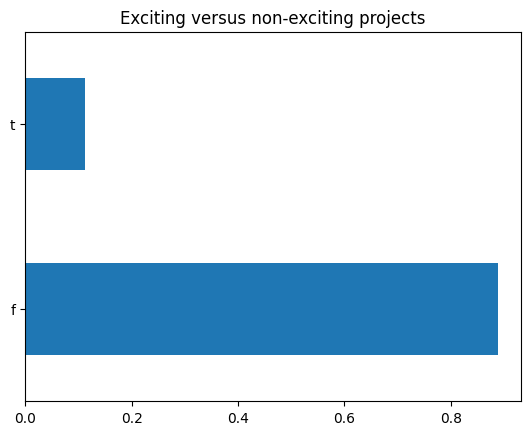

In [19]:
print(df_projects["is_exciting"].value_counts(normalize=True))
df_projects["is_exciting"].value_counts(normalize=True).plot.barh(title="Exciting versus non-exciting projects")

#### What is the historical distribution of exciting versus non-exciting projects?

In [20]:
temp_ = df_projects[["is_exciting","date_posted", "projectid"]].set_index("date_posted")
historical_dis = temp_.groupby([temp_.index.year, "is_exciting"])["projectid"].count().unstack().reset_index()
historical_dis['is_exciting_prop'] = np.round(historical_dis.t/(historical_dis.f+historical_dis.t),2)
historical_dis

is_exciting,date_posted,f,t,is_exciting_prop
0,2002,264.0,NaN,NaN
1,2003,982.0,NaN,NaN
2,2004,2295.0,NaN,NaN
3,2005,4569.0,NaN,NaN
4,2006,10089.0,NaN,NaN
5,2007,15730.0,NaN,NaN
6,2008,23745.0,NaN,NaN
7,2009,31854.0,NaN,NaN
8,2010,40895.0,5099.0,0.11
9,2011,47507.0,9578.0,0.17


#### Do high proportion of great messages leads to exciting projects?
From the graph below, projects with high proportion of great messages are generally exciting

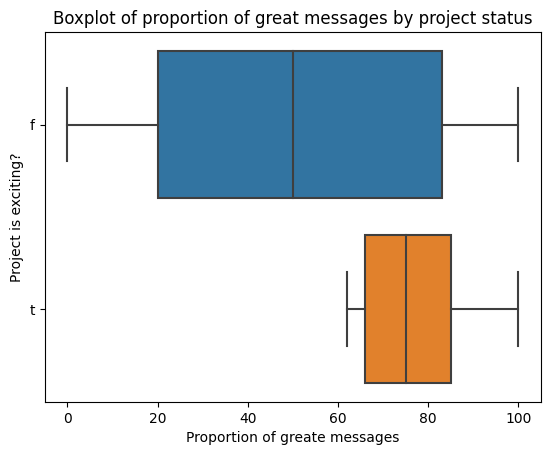

In [21]:
## ---- barchart of great messages vs project status
sns.boxplot( y=df_projects['is_exciting'], x=df_projects['great_messages_proportion'])\
.set(title = "Boxplot of proportion of great messages by project status",
    xlabel = "Proportion of greate messages",
    ylabel = "Project is exciting?")
plt.show()

#### Do high proportion of teacher referrals leads to exciting projects?
From the graph below, there a lot of outlier variables masking the underlying relationship. The second graph removes the outliers and it is clearly observable that projects with high count of teacher referrals are exciting.

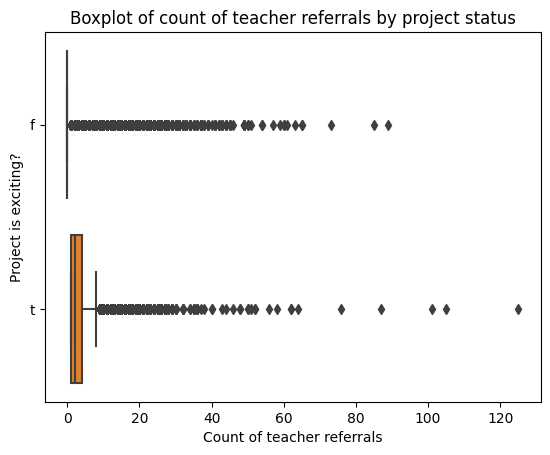

In [22]:
# ---- bar chart of count of teacher referrals by project status
sns.boxplot( y=df_projects['is_exciting'], 
            x=df_projects['teacher_referred_count'])\
.set(title = "Boxplot of count of teacher referrals by project status",
    xlabel = "Count of teacher referrals",
    ylabel = "Project is exciting?")
plt.show()

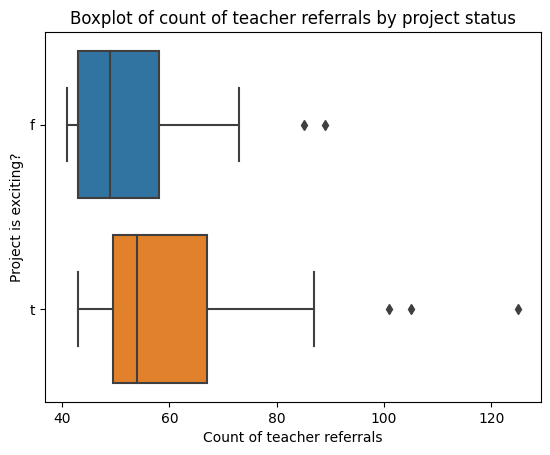

In [23]:
# ---- barchart of teacher referrals
sns.boxplot( y=df_projects.loc[df_projects['teacher_referred_count']>40]['is_exciting'], 
            x=df_projects.loc[df_projects['teacher_referred_count']>40]['teacher_referred_count'])\
.set(title = "Boxplot of count of teacher referrals by project status",
    xlabel = "Count of teacher referrals",
    ylabel = "Project is exciting?")
plt.show()

### Exploratory analysis of categorical features

From the series of stacked bar charts below, the only a few categorical variables seems to have a somewhat influence on whether a project is exciting. These categorical variables include whether the school is a new leader, and whether the schools is a college prep school. Other variables like poeverty level, school county primary focus and the others do not have a clear influence on whether a project is exciting or not.

In [24]:
# ---- function to plot stacked bar chart given a categorical variable
def get_stack_plot(cat_var):
    np.random.seed(123)
    cross_tab_prop = pd.crosstab(index=df_projects[cat_var],
                                 columns=df_projects['is_exciting'],
                                 normalize="index")

    cross_tab_prop.plot(kind='barh', 
                            stacked=True, 
                            colormap='tab10', 
                            figsize=(10, 6))

    plt.legend(loc="lower left", ncol=2)
    plt.ylabel("Project is exciting?")
    plt.xlabel(cat_var.replace("_"," "))
    plt.title(f"Project status by {cat_var.replace('_',' ')}")
    return plt.show()

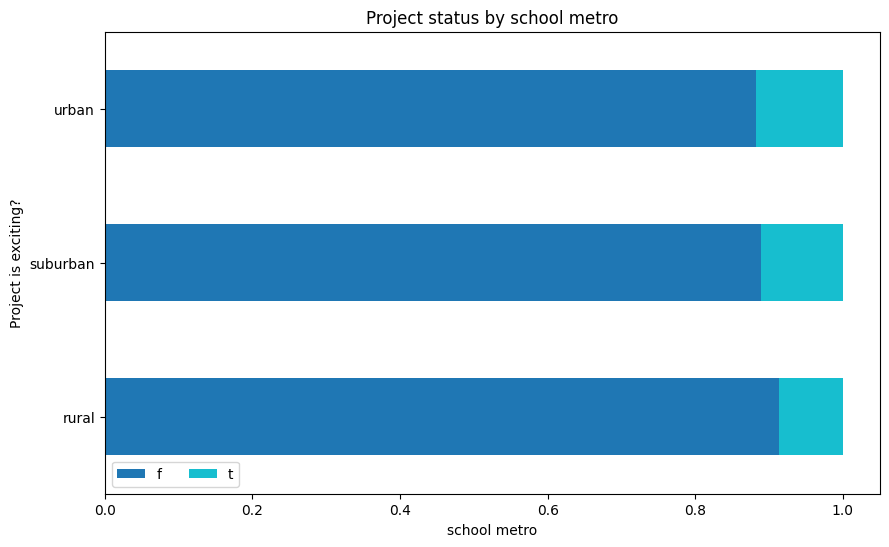

None


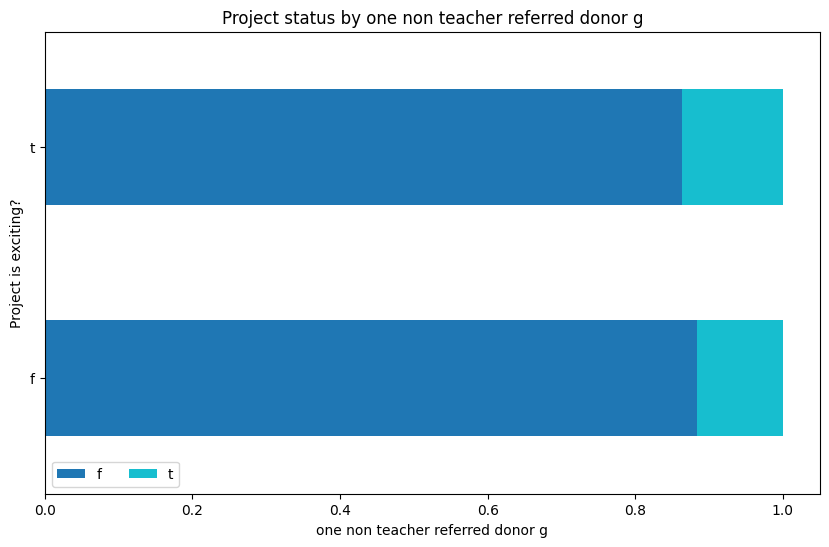

None


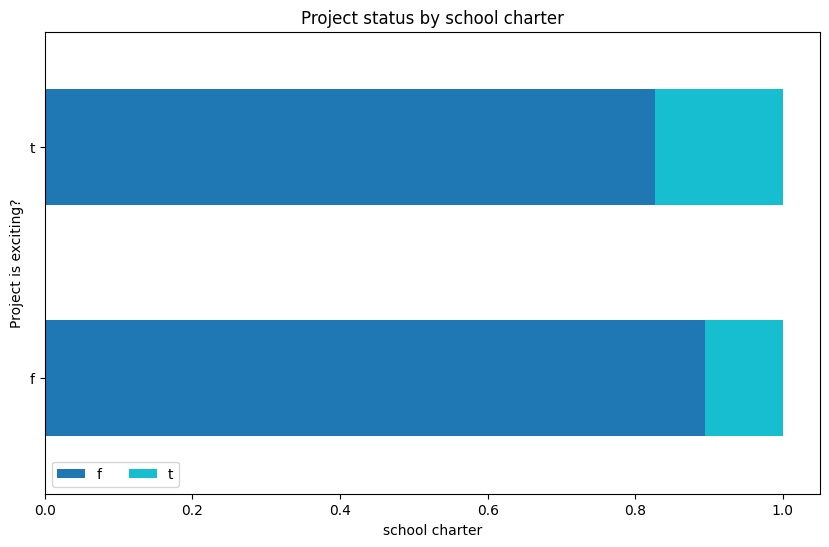

None


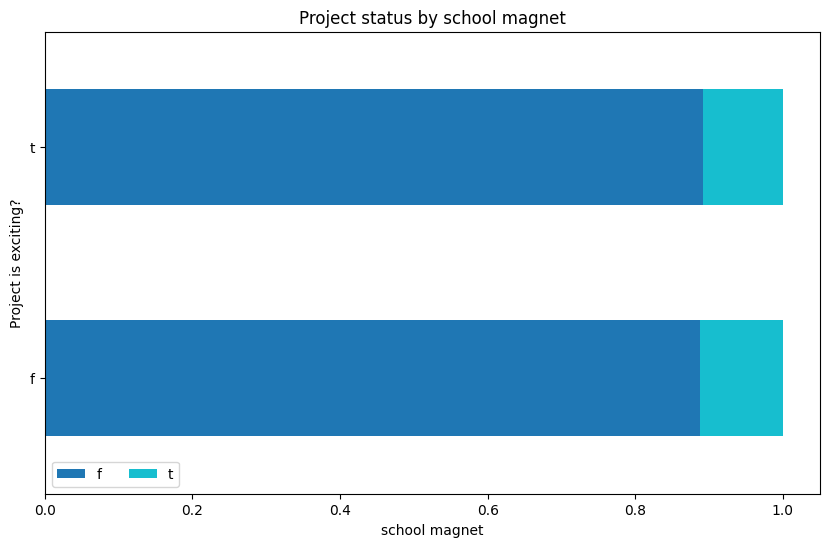

None


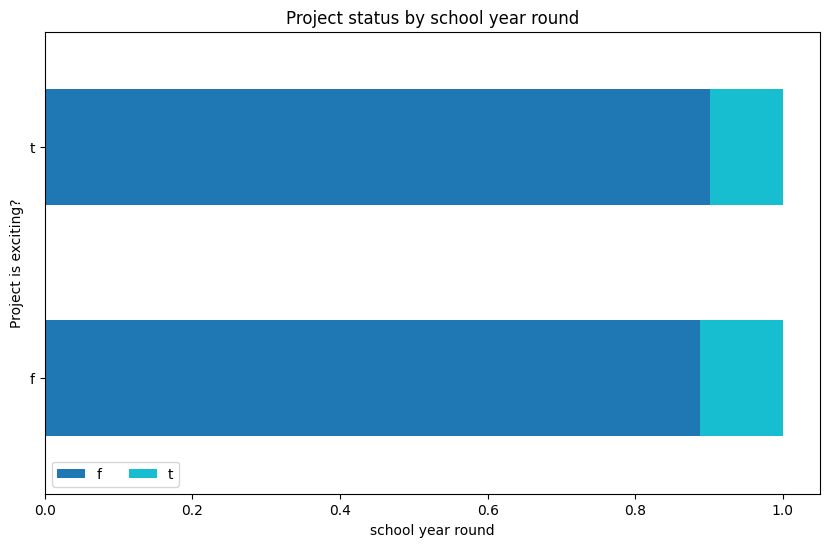

None


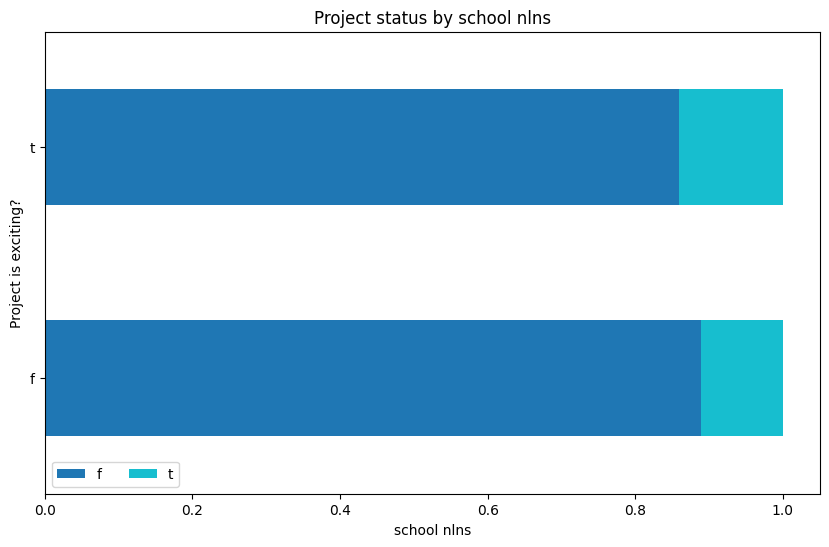

None


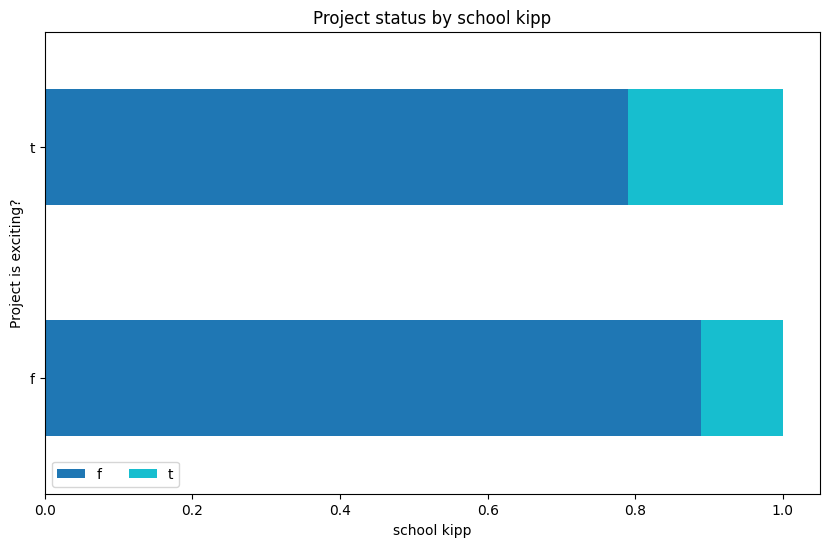

None


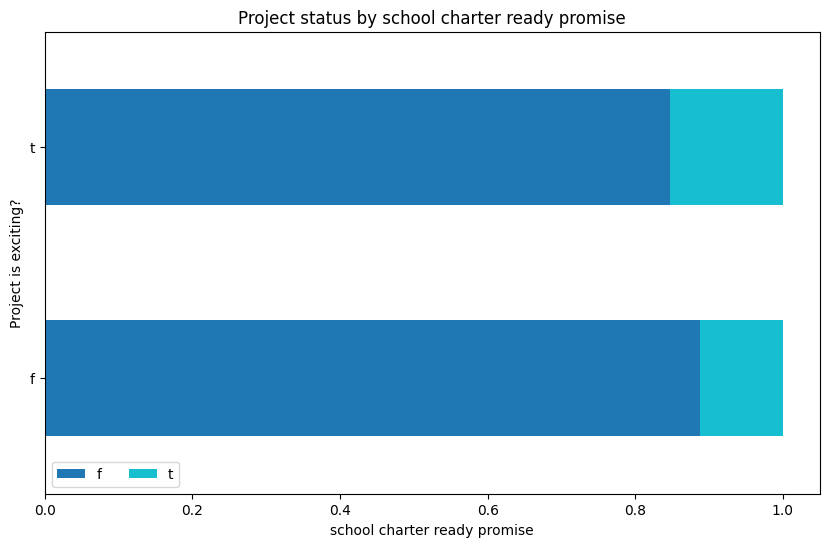

None


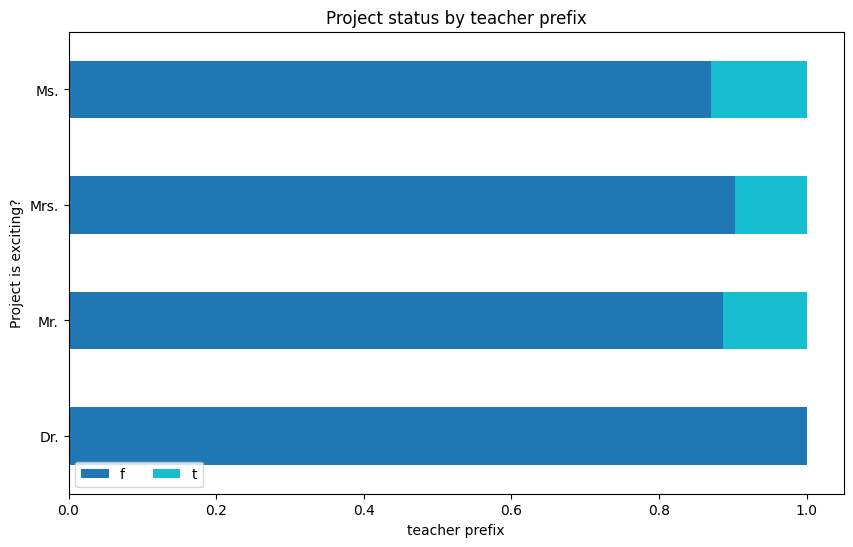

None


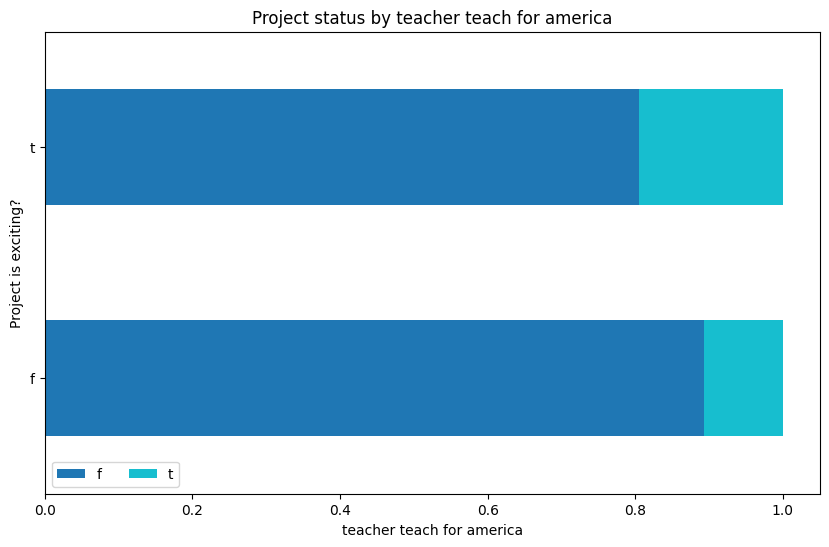

None


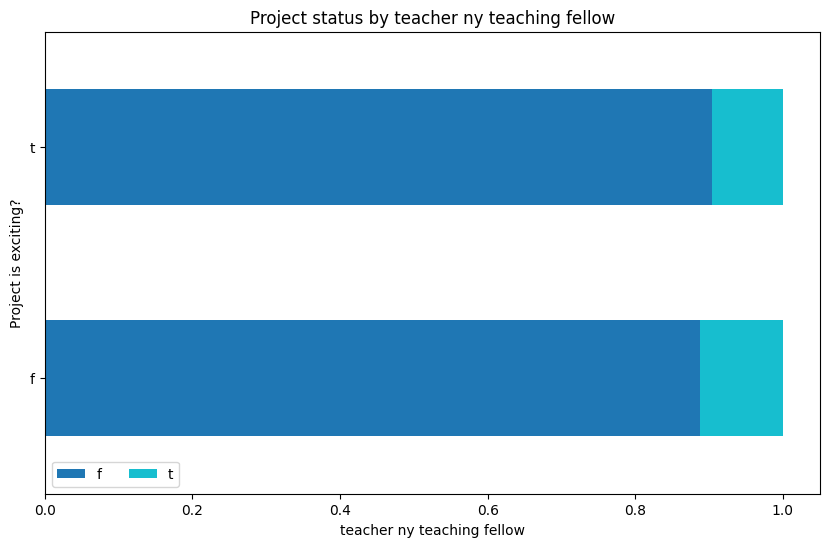

None


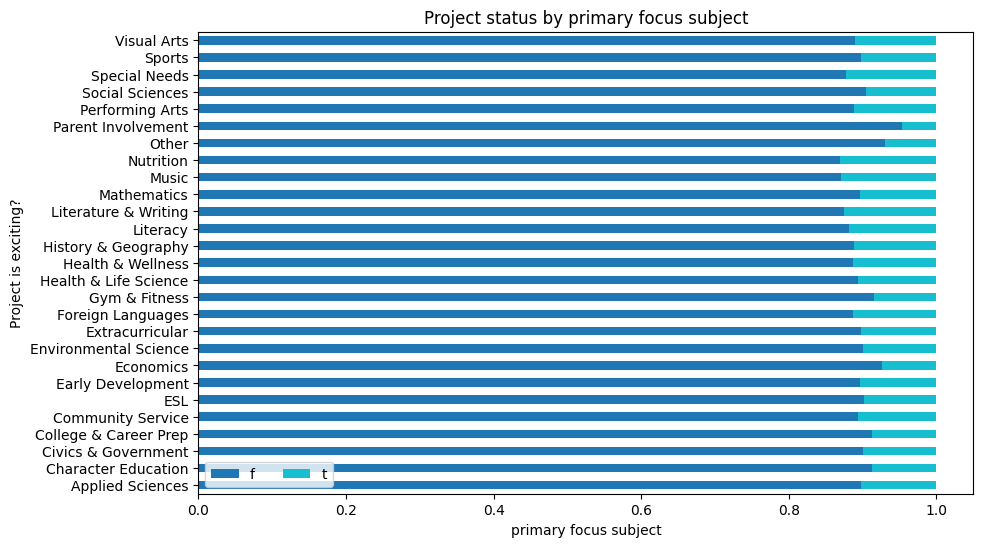

None


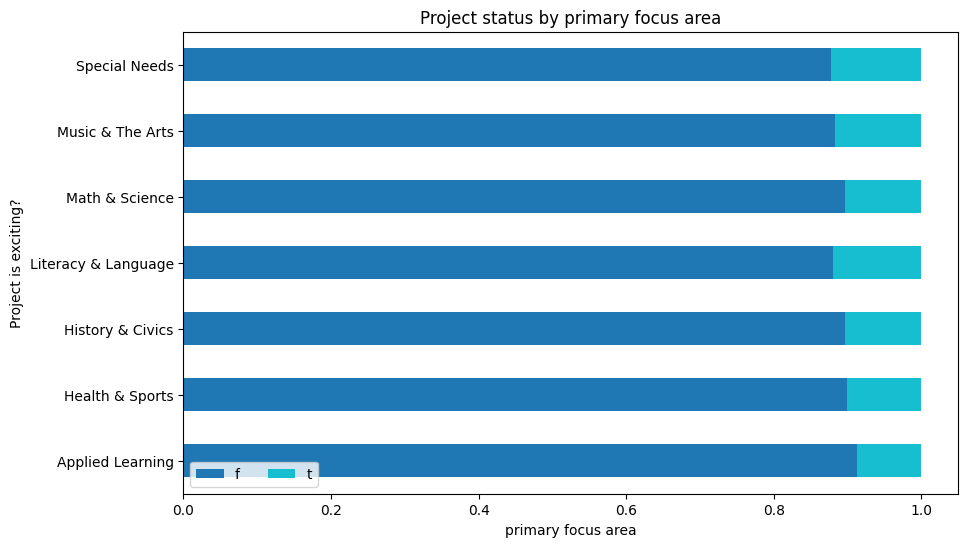

None


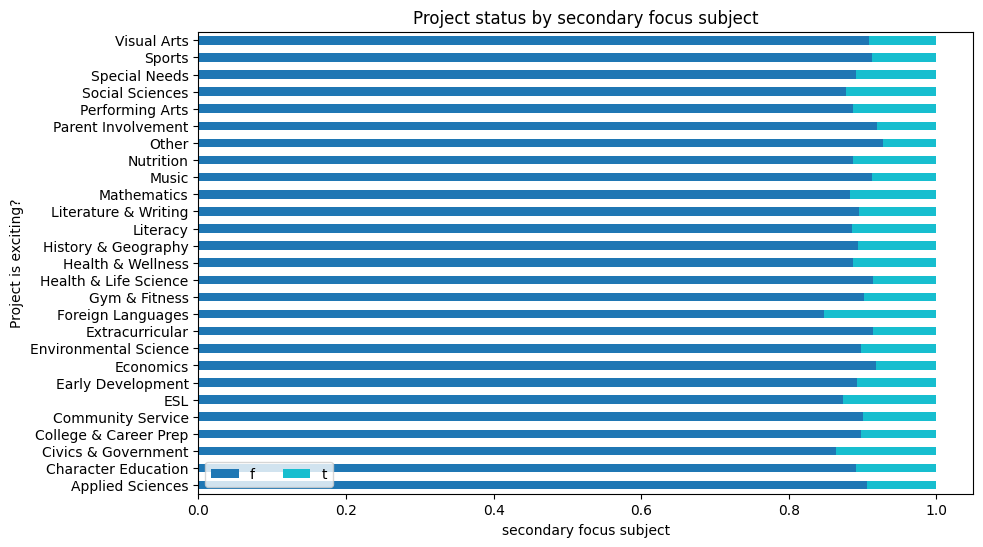

None


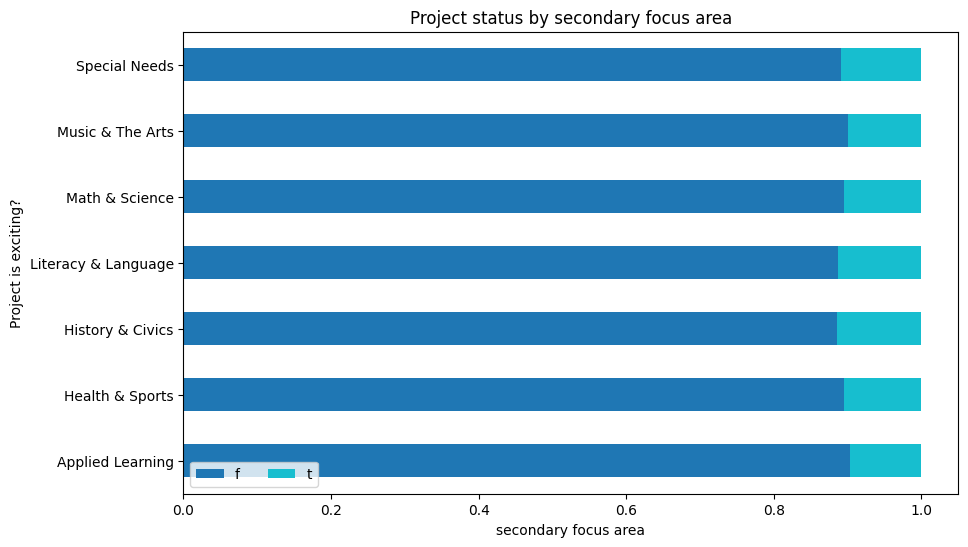

None


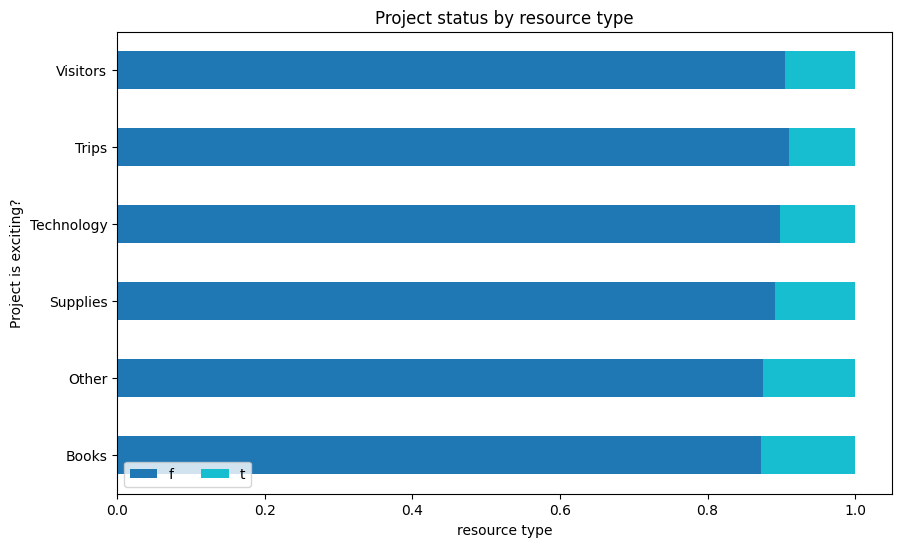

None


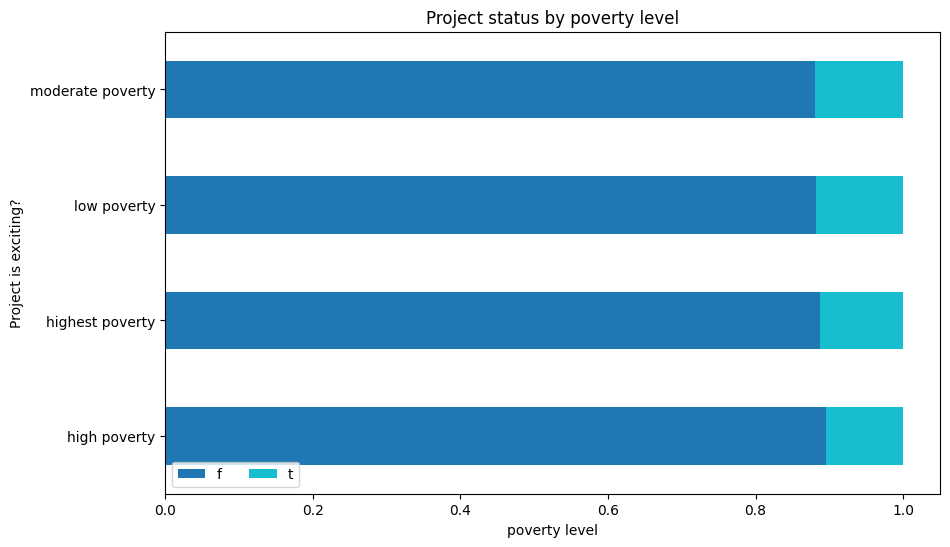

None


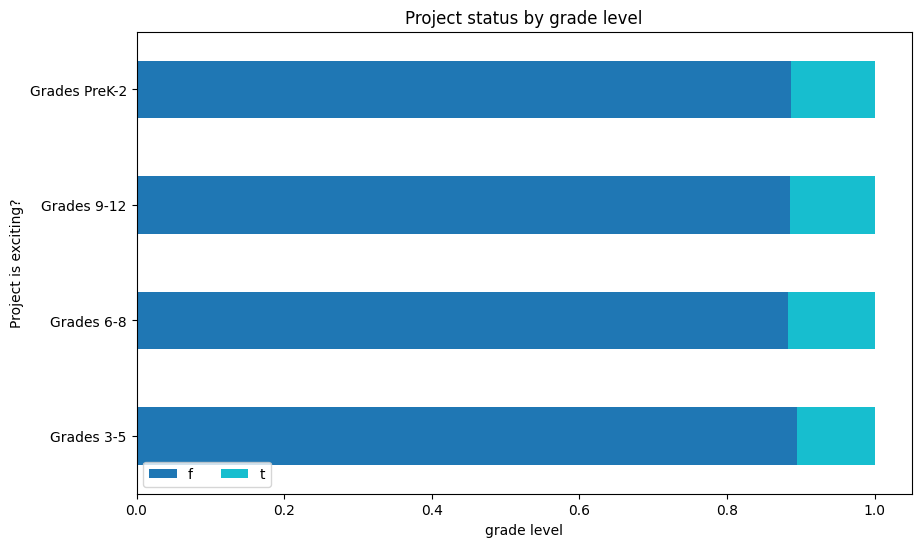

None


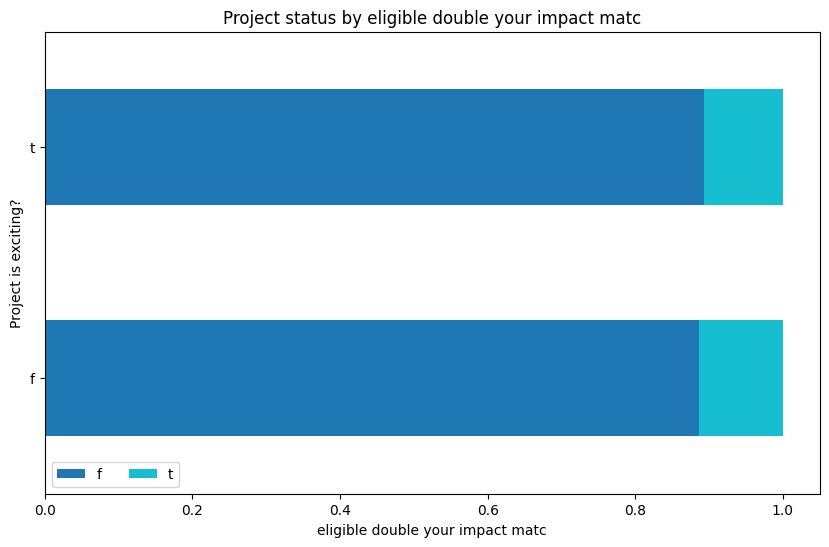

None


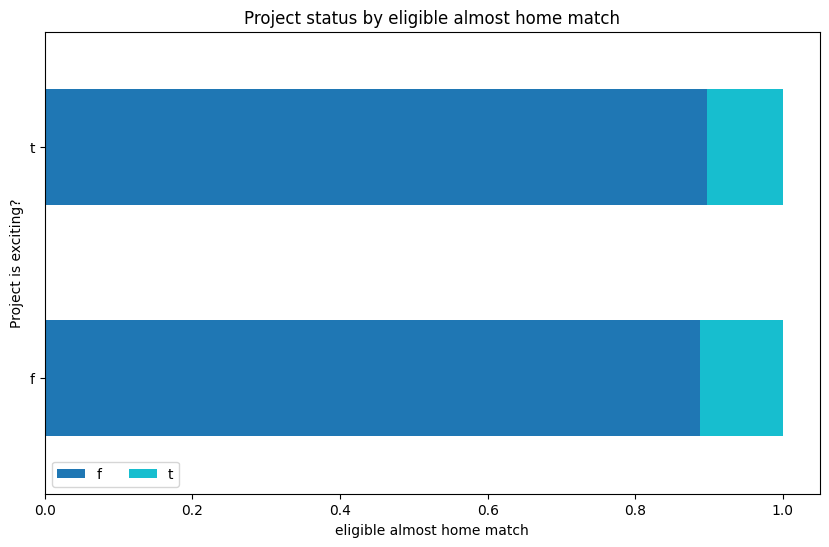

None


In [25]:
# ---- iterate over categorical variables and plot stacked bar charts
for col in ['school_metro', 'one_non_teacher_referred_donor_g', 'school_charter',
       'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp',
       'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'eligible_double_your_impact_matc',
       'eligible_almost_home_match']:
    print(get_stack_plot(col))

## Model building - predicting exciting projects

### Train - test split

The training and testing split is done by the date the event is posted as opposed to a random sample split. The reason for this is that it observations are timerelated and a random sample will lead to feature leakage causing the model to overfit in production.

In [26]:
# ---- sort the data by date_posted for  time splitting
df_projects_sorted = df_projects.sort_values(by = "date_posted").copy()

# ---- generate the split indexes. 
tscv = TimeSeriesSplit(n_splits=2)
_, split_two = tscv.split(df_projects_sorted)

# ---- Generate split train_test split indexes for based on the entire dataset
train_index, test_index = split_two

print("number of observations in training: {}".format(train_index.shape[0]))
print("number of observations in training: {}\n".format(test_index.shape[0]))

print("train pct: {:2.0%}".format(train_index.shape[0]/df_projects_sorted.shape[0]))
print("test  pct: {:2.0%}".format(test_index.shape[0]/df_projects_sorted.shape[0]))


number of observations in training: 218679
number of observations in training: 109339

train pct: 67%
test  pct: 33%


In [27]:
# ---- generate the split indexes to use to sample the data
_,sample_split = tscv.split(df_projects_sorted.iloc[train_index,:])

# ---- Generate split sample train_test split indexes
sample_train_idx, sample_test_idx = sample_split

print("number of sample observations for training: {}".format(sample_train_idx.shape[0]))
print("number of sample observations for testing: {}\n".format(sample_test_idx.shape[0]))

print("sample train pct: {:2.0%}".format(sample_train_idx.shape[0]/df_projects_sorted.iloc[train_index,:].shape[0]))
print("sample test  pct: {:2.0%}".format(sample_test_idx.shape[0]/df_projects_sorted.iloc[train_index,:].shape[0]))

number of sample observations for training: 145786
number of sample observations for testing: 72893

sample train pct: 67%
sample test  pct: 33%


### Pipelines

In [28]:
#categorical feature list
cat_features = [
    "teacher_teach_for_america",
    "one_non_teacher_referred_donor_g",
    "eligible_double_your_impact_matc",
]

#categorical levels for categorical features encoding
true_false_levels = ['f','t']
metro_levels = ["rural", "suburban", "urban"]
teacher_levels = ["Ms.", "Mrs.", "Mr.", "Dr."]
resource_type_levels = [
    "Visitors",
    "Trips",
    "Other",
    "Books",
    "Technology",
    "Supplies",
]
poverty_levels = [
    "low poverty",
    "moderate poverty",
    "high poverty",
    "highest poverty",
]
primary_area_levels = [
    "Health & Sports",
    "History & Civics",
    "Applied Learning",
    "Special Needs",
    "Math & Science",
    "Literacy & Language",
]
#numeric feature list
num_features= [
        "great_messages_proportion",
        "teacher_referred_count",
        "non_teacher_referred_count",
        "students_reached",
        "fulfillment_labor_materials",
        "total_price_excluding_optional_s",
    ] 

#Target variagle
target = ['is_exciting']

#categorical pipeline
cat_pipe = Pipeline([
    ('label',  OrdinalEncoder(categories=[ true_false_levels,
                         true_false_levels,
                         true_false_levels,], 
                              handle_unknown= "use_encoded_value",
                              unknown_value= -1, 
                              encoded_missing_value=-2))
])

#numeric pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

#Data processing pipeline
preprocessing = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat_features),
    ('num', num_pipe, num_features)
    ])


# Input dataframe and target dataframe
X = df_projects_sorted[cat_features + num_features]
y = df_projects_sorted[target].is_exciting.map({"t":1,"f":0}).to_frame()

# Training and test set for the full data
X_train = X.iloc[train_index,:]
y_train = y.iloc[train_index,:]

X_test = X.iloc[test_index,:]
y_test = y.iloc[test_index,:]

# Training and test set for the sample data
X_train_sample = X.iloc[sample_train_idx,:]
y_train_sample = y.iloc[sample_train_idx,:]

X_test_sample = X.iloc[sample_test_idx,:]
y_test_sample = y.iloc[sample_test_idx,:]

### Model Evaluation Function

In [29]:
# ---- Evaluation metrics function

def eval_metrics(model,X,y_true):
    auc = metrics.roc_auc_score(y_true = y_true,
                                 y_score = model.predict(X))
    accuracy = metrics.accuracy_score(y_true = y_true,
                                y_pred = model.predict(X))
    recall = metrics.recall_score(y_true = y_true,
                                 y_pred = model.predict(X))
    precision = metrics.precision_score(y_true = y_true,
                                 y_pred = model.predict(X))
    log_loss = metrics.log_loss(y_true = y_true,
                                 y_pred = model.predict(X))
    return {"roc_auc":round(auc, 4),
            "min_log_loss":round(log_loss, 4),
           "accuracy":round(accuracy,4),
           "recall":round(recall,2),
           "precision": round(precision,2)}


### Function to chart variable importance

In [30]:
#Function to plot model importance

def model_var_importance(model, model_name, feature_names):
    
    # -- get feature importance 
    importance = model.feature_importances_

    # -- summarize feature importance into a dictionary 
    feature_imp ={}
    for i,v in enumerate(importance):
        items = feature_names[i].split('_')
        if items[0].isdigit():
            fname = cat_features[int(items[0])] + "_" + items[1]
            feature_imp[fname] = v
        else:
            feature_imp[feature_names[i]] = v
            #print(items[0].isdigit())
            #print(items)
        #if int(items[0]) >= 0:  
        #print(categorical_features[int(items[0])])

    # make the dictionary a data frame 
    feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                         columns=['importance'])

    # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
    feature_imp = (feature_imp
                   .reset_index()
                   .rename(columns={'index':'feature'})
                   .sort_values('importance',ascending=False)
                   .query('importance > 0.001'))

    # -- plot that 
    plt.figure(figsize=(10,10))
    sns.barplot(x="importance", y="feature", data=feature_imp, color="lightblue")
    plt.title( model_name + 'Variable Iportance')
    plt.ylabel('Feature')
    plt.xlabel('Importance ')
    plt.xticks(rotation=45)
    plt.show()
    
# -- creates one list of all the feature names. 
feature_names =  cat_features + num_features

### Model 1 - Logistic Regression using sample data

In [31]:
# ---- Pipeline for model

log_regressor = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', LogisticRegression(verbose = 1, max_iter=500 ))
])


# ---- model fitting on sample data
log_regressor = log_regressor.fit(X_train_sample, y_train_sample.values.ravel())
log_regressor

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01051D+05    |proj g|=  3.88078D+07

At iterate   50    f=  2.44762D+04    |proj g|=  2.71410D+03

At iterate  100    f=  1.41560D+04    |proj g|=  3.86069D+04

At iterate  150    f=  1.27310D+04    |proj g|=  5.37068D+04

At iterate  200    f=  1.19040D+04    |proj g|=  4.59379D+03

At iterate  250    f=  1.18491D+04    |proj g|=  1.77418D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10    292    395      1     0     0   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s finished


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder(categories=[['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't']],
                                                                                  encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['teacher_teach_for_america',
                                                   'one_non_teacher_referred_donor_g',
                                                   'eligible_double_your_impact_matc']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['great_messages_proportion',
                                                   'teacher_referred_count',
                                                   'non_teacher_referred_count',
                                                   'students_reached',
                                                   'fulfillment_labor_materials',
                                                   'total_price_excluding_optional_s'])])),
                ('regressor', LogisticRegression(max_iter=500, verbose=1))])

### Model 1 - Evaluation using sample data

In [32]:
print(f"Training : {eval_metrics(log_regressor, X = X_train_sample, y_true = y_train_sample)}")
print(f"Testing : {eval_metrics(log_regressor, X = X_test_sample, y_true = y_test_sample)}")

Training : {'roc_auc': 0.7222, 'min_log_loss': 1.0818, 'accuracy': 0.9687, 'recall': 0.45, 'precision': 0.8}
Testing : {'roc_auc': 0.7155, 'min_log_loss': 3.8499, 'accuracy': 0.8885, 'recall': 0.47, 'precision': 0.68}


### Model 1 - Evaluation using full data

In [33]:
# ---- Load model trained on full data
with open("../models_all_params/log.pickle", "rb") as f:
    log_offline = pickle.load(f)

# ---- Model evaluation metrics
log_train = eval_metrics(log_offline, X = X_train, y_true = y_train)
log_test = eval_metrics(log_offline, X = X_test, y_true = y_test)
log_result = pd.DataFrame([log_train, log_test], index = ['log_train', 'log_test'])
log_result

,roc_auc,min_log_loss,accuracy,recall,precision
log_train,0.7101,2.3415,0.9322,0.45,0.61
log_test,0.5995,5.0972,0.8524,0.21,0.77


### Model 2 - Decision Tree Classifier using sample data

In [34]:
# ---- Param Grid for Randomized search CV
param_grid = {"splitter":["best","random"],
            "max_depth" : [3,5]}

tsplit = TimeSeriesSplit(n_splits=5)

# ---- Randomized search cv
random_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                           param_distributions=param_grid,
                           scoring="accuracy",
                           n_jobs = 3,
                           cv=tsplit, 
                           verbose=1,
                            random_state=42)

# ---- Pipeline for Random Forest tuning
dtc_pipe = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', random_search)
])

# ---- Model fitting on sample data
dtc = dtc_pipe.fit(X_train_sample, y_train_sample.values.ravel())
dtc

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder(categories=[['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't']],
                                                                                  encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['teacher_teach_for_america',
                                                   'one_non_teacher_referred_donor_g',
                                                   'eligible_double_your_impact_matc']),
                                                 ('num',
                                                  Pipeline(...
                                                   'students_reached',
                                                   'fulfillment_labor_materials',
                                                   'total_price_excluding_optional_s'])])),
                ('regressor',
                 RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                    estimator=DecisionTreeClassifier(),
                                    n_jobs=3,
                                    param_distributions={'max_depth': [3, 5],
                                                         'splitter': ['best',
                                                                      'random']},
                                    random_state=42, scoring='accuracy',
                                    verbose=1))])

### Model 2 - Evaluation  using sample data

In [35]:
print(f"Training : {eval_metrics(dtc, X = X_train_sample, y_true = y_train_sample)}")
print(f"Testing : {eval_metrics(dtc, X = X_test_sample, y_true = y_test_sample)}")

Training : {'roc_auc': 0.9972, 'min_log_loss': 0.1156, 'accuracy': 0.9967, 'recall': 1.0, 'precision': 0.94}
Testing : {'roc_auc': 0.993, 'min_log_loss': 0.344, 'accuracy': 0.99, 'recall': 1.0, 'precision': 0.94}


### Model 2 Archictecture using full data

In [36]:
# ---- Load model trained on full data
with open("../models_all_params/dtc.pickle", "rb") as f:
    dtc_offline = pickle.load(f)
    
dtc_offline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder(categories=[['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't']],
                                                                                  encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['teacher_teach_for_america',
                                                   'one_non_teacher_referred_donor_g',
                                                   'eligible_double_your_impact_matc']),
                                                 ('num',
                                                  Pipeline(...
                                                   'students_reached',
                                                   'fulfillment_labor_materials',
                                                   'total_price_excluding_optional_s'])])),
                ('scaler', StandardScaler()),
                ('regressor',
                 RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                    estimator=DecisionTreeClassifier(),
                                    n_jobs=-1,
                                    param_distributions={'max_depth': [3, 5],
                                                         'splitter': ['best',
                                                                      'random']},
                                    scoring='accuracy', verbose=1))])

In [37]:
# --- Model parameters
dtc_offline.named_steps.regressor.best_params_

{'splitter': 'best', 'max_depth': 5}

### Model 2 - Evaluation using full data

In [38]:
# ---- Model metrics on full data
dtc_train = eval_metrics(dtc_offline, X = X_train, y_true = y_train)
dtc_test = eval_metrics(dtc_offline, X = X_test, y_true = y_test)
dtc_result = pd.DataFrame([dtc_train, dtc_test], index = ['dtc_train', 'dtc_test'])
dtc_result

,roc_auc,min_log_loss,accuracy,recall,precision
dtc_train,0.9960,0.1914,0.9945,1.0,0.94
dtc_test,0.9937,0.3383,0.9902,1.0,0.95


### Model 2 - visualization of decision tree

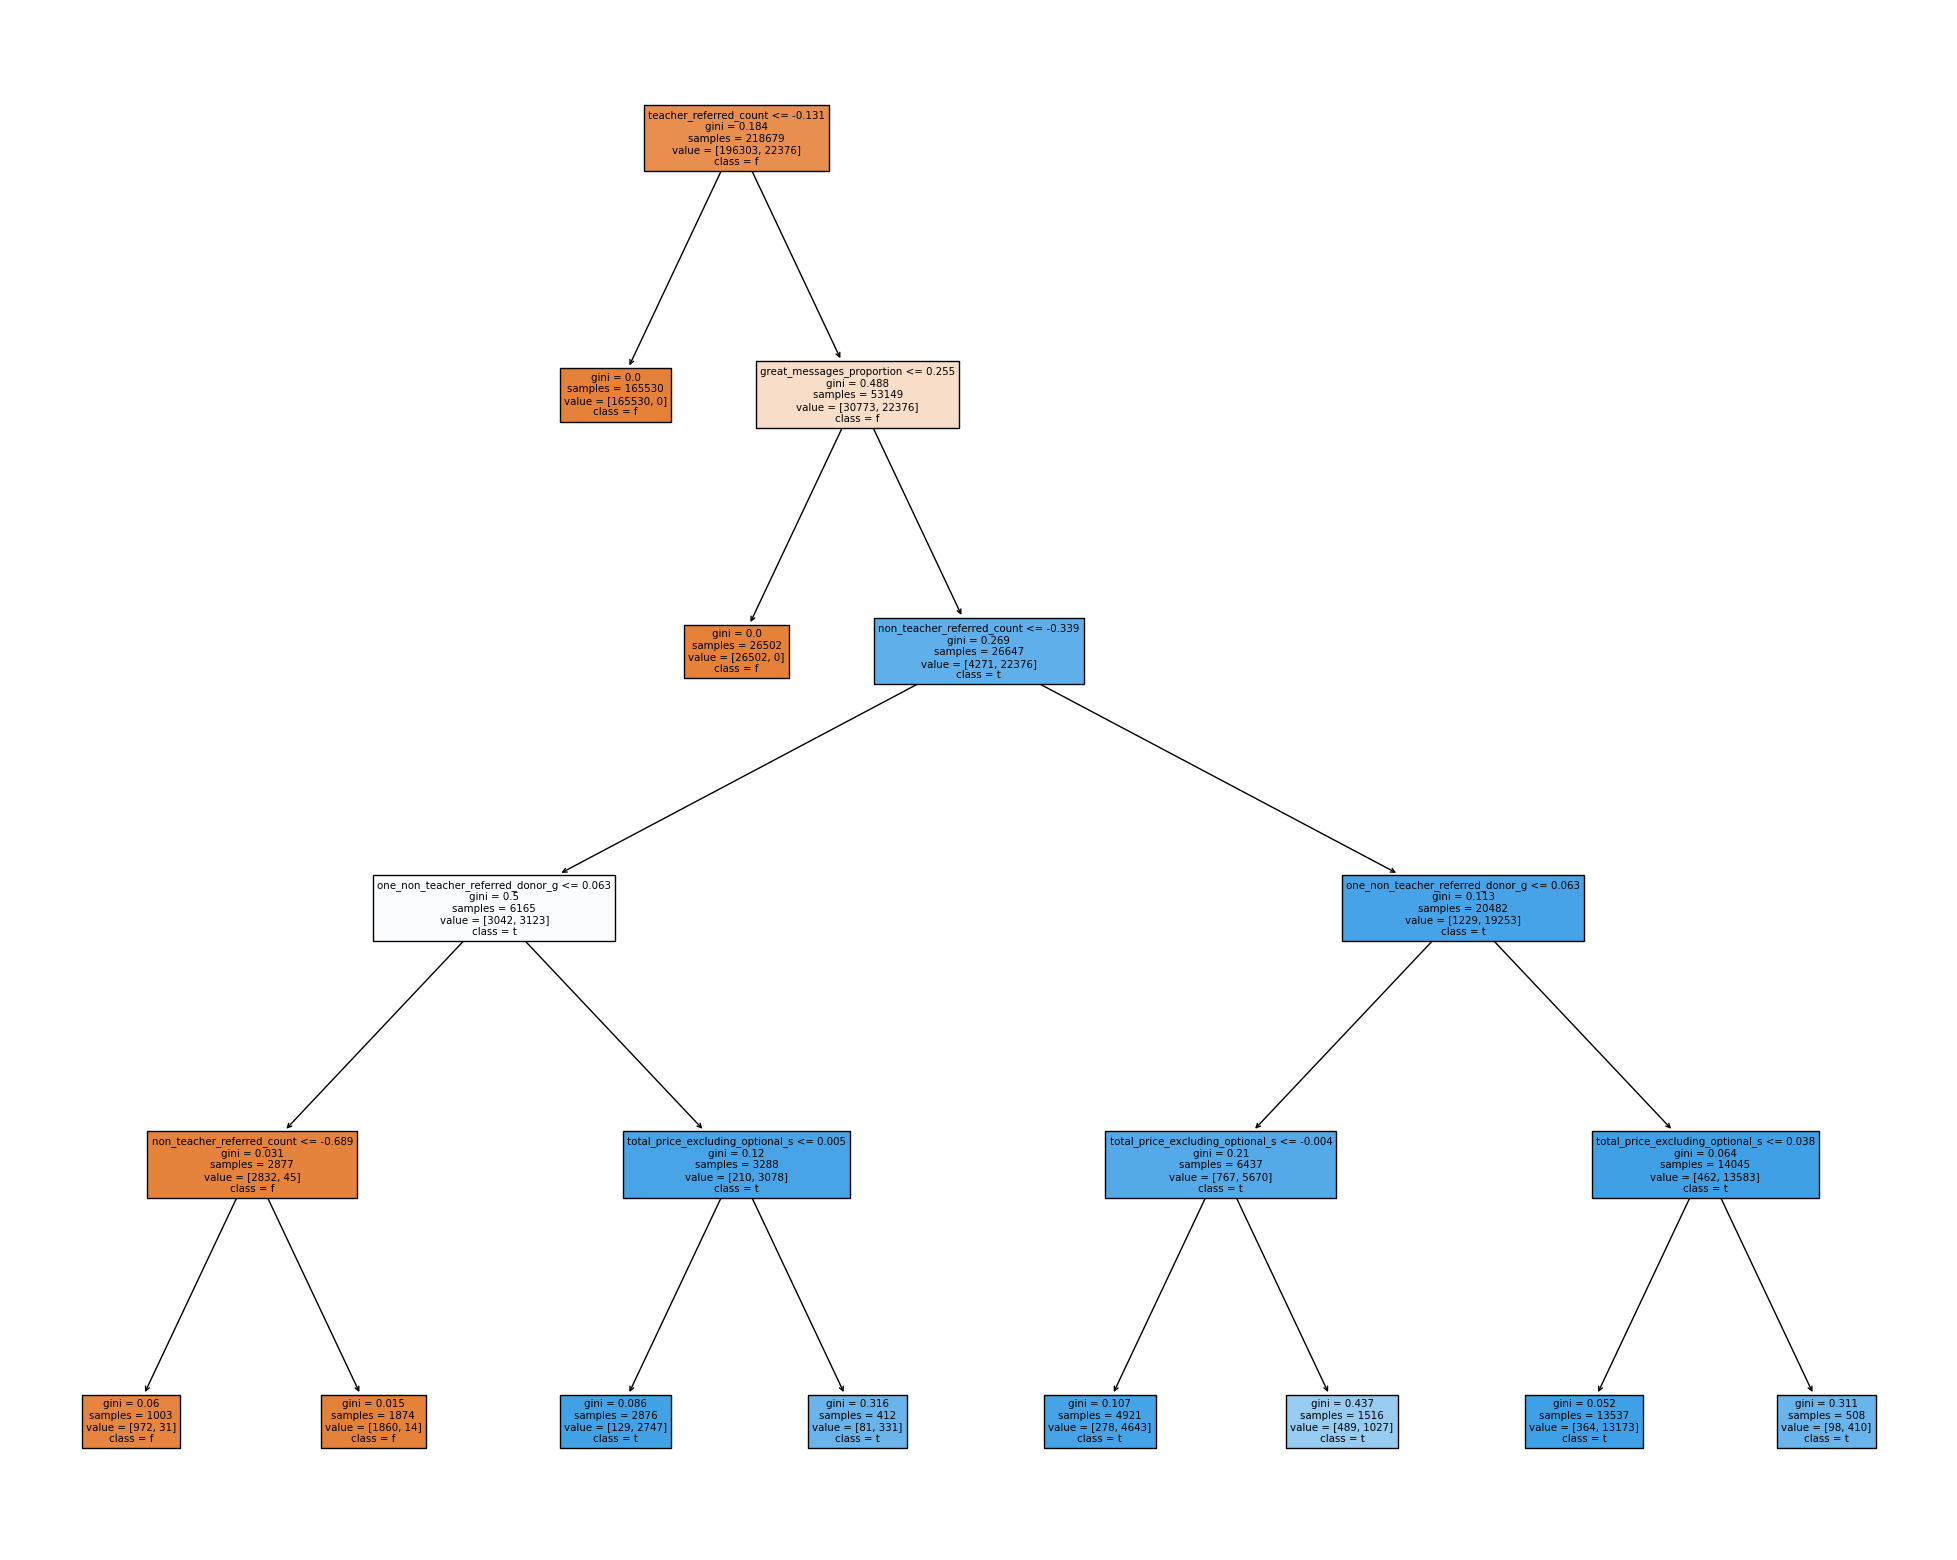

In [39]:
#  ---- plot of decision tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dtc_offline.named_steps.regressor.best_estimator_,
                   feature_names=feature_names,  
                   class_names=["f","t"],
                   filled=True, )

### Model 2  - Variable Importance

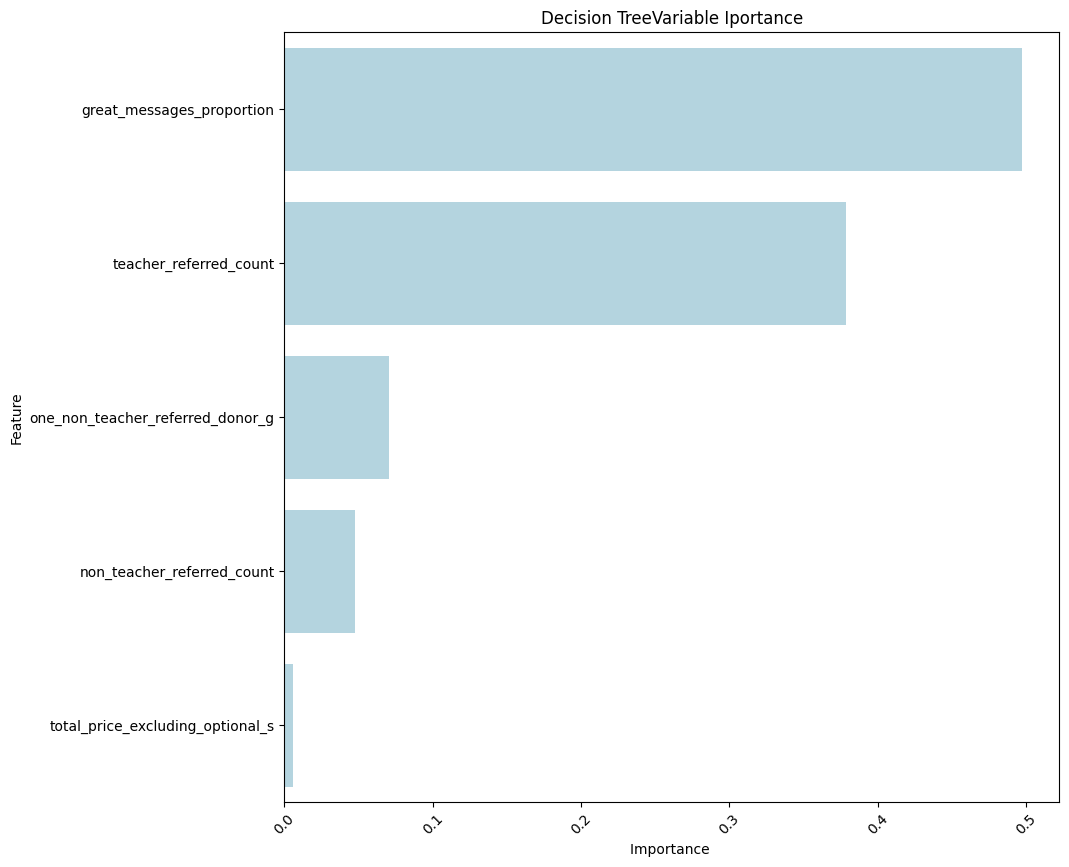

In [40]:
model_var_importance(dtc_offline.named_steps.regressor.best_estimator_, "Decision Tree", feature_names)

### Model 3 - Random Forest

In [41]:
# ---- Param Grid for Randomized search CV
random_grid = {'n_estimators': [500],
               'max_depth': [5,10,15],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}
tsplit = TimeSeriesSplit(n_splits=5)

# ---- Randomized search cv
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                   param_distributions=random_grid,
                                   scoring='accuracy',
                                   n_jobs = 3,
                                   cv=tsplit,
                                   random_state = 42, 
                                   verbose=1)

# ---- Pipeline for Random Forest tuning
rf_pipe = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', random_search)
])

# ---- Model fitting
rf = rf_pipe.fit(X_train_sample, y_train_sample.values.ravel())
rf

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder(categories=[['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't']],
                                                                                  encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['teacher_teach_for_america',
                                                   'one_non_teacher_referred_donor_g',
                                                   'eligible_double_your_impact_matc']),
                                                 ('num',
                                                  Pipeline(...
                                                   'total_price_excluding_optional_s'])])),
                ('regressor',
                 RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                    estimator=RandomForestClassifier(),
                                    n_jobs=3,
                                    param_distributions={'max_depth': [5, 10,
                                                                       15],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              4],
                                                         'min_samples_split': [2,
                                                                               5,
                                                                               10],
                                                         'n_estimators': [500]},
                                    random_state=42, scoring='accuracy',
                                    verbose=1))])

### Model 3 - Evaluation using sample data

In [42]:
print(f"Training : {eval_metrics(rf, X = X_train_sample, y_true = y_train_sample)}")
print(f"Testing : {eval_metrics(rf, X = X_test_sample, y_true = y_test_sample)}")

Training : {'roc_auc': 0.997, 'min_log_loss': 0.0652, 'accuracy': 0.9981, 'recall': 1.0, 'precision': 0.97}
Testing : {'roc_auc': 0.9914, 'min_log_loss': 0.289, 'accuracy': 0.9916, 'recall': 0.99, 'precision': 0.95}


### Model 3 Archictecture using full data

In [43]:
# ---- Load model trained on full data
with open("../models_all_params/rf.pickle", "rb") as f:
    rf_offline = pickle.load(f)
    
rf_offline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder(categories=[['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't']],
                                                                                  encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['teacher_teach_for_america',
                                                   'one_non_teacher_referred_donor_g',
                                                   'eligible_double_your_impact_matc']),
                                                 ('num',
                                                  Pipeline(...
                                                   'total_price_excluding_optional_s'])])),
                ('regressor',
                 RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                    estimator=RandomForestClassifier(),
                                    n_jobs=-1,
                                    param_distributions={'max_depth': [3, 5,
                                                                       10],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              4],
                                                         'min_samples_split': [2,
                                                                               5,
                                                                               10],
                                                         'n_estimators': [500,
                                                                          1000,
                                                                          1500]},
                                    random_state=42, scoring='accuracy',
                                    verbose=1))])

In [44]:
# --- Model parameters
rf_offline.named_steps.regressor.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 10}

### Model 3 - Evaluation using full data

In [45]:
# ---- Model evaluation metrics
rf_test = eval_metrics(rf_offline, X = X_test, y_true = y_test)
rf_train = eval_metrics(rf_offline, X = X_train, y_true = y_train)
rf_result = pd.DataFrame([rf_train, rf_test], index = ['rf_train', 'rf_test'])
rf_result

,roc_auc,min_log_loss,accuracy,recall,precision
rf_train,0.9956,0.1669,0.9952,1.0,0.95
rf_test,0.9944,0.2717,0.9921,1.0,0.96


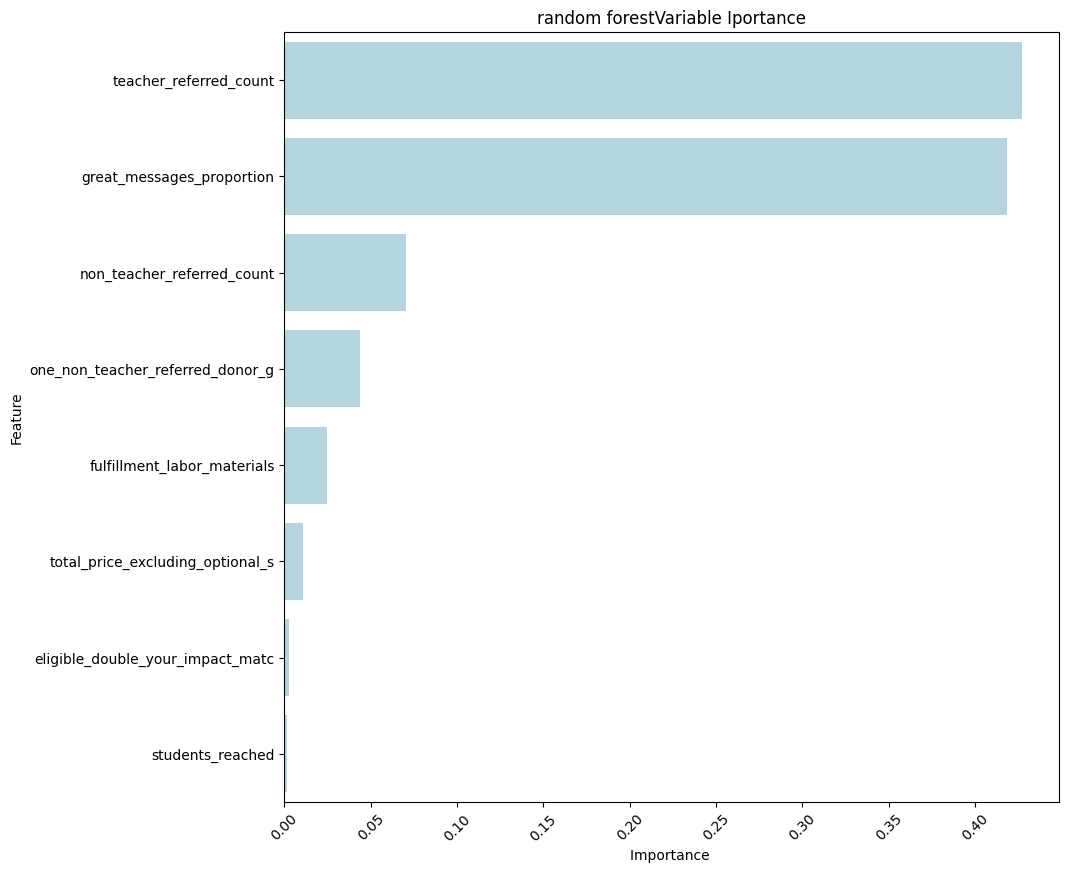

In [46]:
# -- Plot feature importance
model_var_importance(rf_offline.named_steps.regressor.best_estimator_, 'random forest', feature_names)

### Model 4 - Suport Vector Machines

In [47]:
# ---- Pipeline for Random Forest tuning
svm_pipe = Pipeline([
    ('preprocess', preprocessing),
    ('scaler', StandardScaler()),
    ('regressor', SVC(C=0.1,kernel="rbf",gamma="scale"))
])

# ---- Model fitting
svm = svm_pipe.fit(X_train_sample, y_train_sample.values.ravel())
svm

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder(categories=[['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't']],
                                                                                  encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['teacher_teach_for_america',
                                                   'one_non_teacher_referred_donor_g',
                                                   'eligible_double_your_impact_matc']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['great_messages_proportion',
                                                   'teacher_referred_count',
                                                   'non_teacher_referred_count',
                                                   'students_reached',
                                                   'fulfillment_labor_materials',
                                                   'total_price_excluding_optional_s'])])),
                ('scaler', StandardScaler()), ('regressor', SVC(C=0.1))])

### Model 4 - Evaluation using sample dataa

In [48]:
print(f"Training : {eval_metrics(rf, X = X_train_sample, y_true = y_train_sample)}")
print(f"Testing : {eval_metrics(rf, X = X_test_sample, y_true = y_test_sample)}")

Training : {'roc_auc': 0.997, 'min_log_loss': 0.0652, 'accuracy': 0.9981, 'recall': 1.0, 'precision': 0.97}
Testing : {'roc_auc': 0.9914, 'min_log_loss': 0.289, 'accuracy': 0.9916, 'recall': 0.99, 'precision': 0.95}


### Model 4 - Architecture using full data

In [49]:
# ---- Load model trained on full data
with open("../models_all_params/svm.pickle", "rb") as f:
    svm_offline = pickle.load(f)
    
svm_offline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder(categories=[['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't'],
                                                                                              ['f',
                                                                                               't']],
                                                                                  encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['teacher_teach_for_america',
                                                   'one_non_teacher_referred_donor_g',
                                                   'eligible_double_your_impact_matc']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['great_messages_proportion',
                                                   'teacher_referred_count',
                                                   'non_teacher_referred_count',
                                                   'students_reached',
                                                   'fulfillment_labor_materials',
                                                   'total_price_excluding_optional_s'])])),
                ('scaler', StandardScaler()), ('regressor', SVC(C=0.1))])

In [50]:
# --- Model parameters
svm_offline.named_steps.regressor.get_params()

{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Model 4 - Evaluation using full data

In [52]:
svm_test = eval_metrics(svm_offline, X = X_test, y_true = y_test)
svm_train = eval_metrics(svm_offline, X = X_train, y_true = y_train)
svm_result = pd.DataFrame([svm_train, svm_test], index = ['svm_train', 'svm_test'])
svm_result

,roc_auc,min_log_loss,accuracy,recall,precision
svm_train,0.9429,0.5834,0.9831,0.89,0.90
svm_test,0.9510,1.1151,0.9677,0.93,0.89


## Model selection
From the table below,the performance of the random forest model in terms of roc_auc is margins better than the decition tree model.


However, we are selecting the decisoin tree model because of the following reasons
1. It has a faster inference time than the random forest
2. It will take less time to retrained
3. It has higher interpretability
4. It requires no feature scalling

In [53]:
pd.concat([log_result, dtc_result, rf_result, svm_result])

,roc_auc,min_log_loss,accuracy,recall,precision
log_train,0.7101,2.3415,0.9322,0.45,0.61
log_test,0.5995,5.0972,0.8524,0.21,0.77
dtc_train,0.9960,0.1914,0.9945,1.00,0.94
dtc_test,0.9937,0.3383,0.9902,1.00,0.95
rf_train,0.9956,0.1669,0.9952,1.00,0.95
rf_test,0.9944,0.2717,0.9921,1.00,0.96
svm_train,0.9429,0.5834,0.9831,0.89,0.90
svm_test,0.9510,1.1151,0.9677,0.93,0.89


## Model Scoring with final model (Decision Tree)

### Model scoring using test data

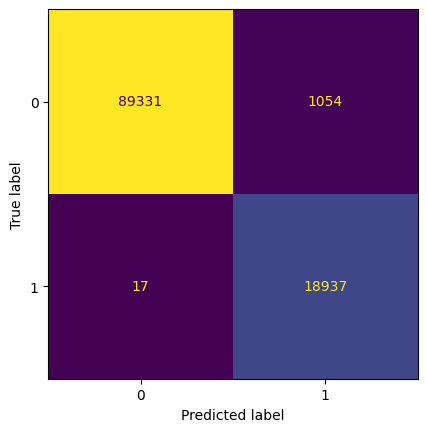

In [54]:
y_pred = dtc_offline.predict(X_test)
metrics.plot_confusion_matrix(dtc_offline,
                              X=X_test,
                              y_true = y_test,colorbar=False)

### Business operation of the model

In [55]:
# --- function to return predicted rate of exciting, and its corresponding false positive rate
def op_level(X, y_true, threshold = 0.5):
    y_proba = dtc_offline.predict_proba(X=X)[:,1]
    y_pred = [1 if x>=threshold else 0 for x in y_proba]
    conf_matrix = metrics.confusion_matrix(y_true = y_true, y_pred=y_pred)
    fp = conf_matrix[0,1]
    tp = conf_matrix[1,1]
    tn = conf_matrix[0,0]
    fn = conf_matrix[1,0]
    n_obs = conf_matrix.sum()
    err = round(1-((tp+tn)/n_obs),4)
    p_exciting = round((tp+fp)/n_obs,2)
    gain = (tp+fp)-(tp+fn)
    
    return gain,p_exciting,err

#### For example, given 2013 data, what would be the predicted rate of exciting projects for donorschoose?

In [56]:
X_2013 = df_projects_sorted[df_projects_sorted["date_posted"].dt.year == 2013][cat_features+num_features]
y_2013 = df_projects_sorted[df_projects_sorted["date_posted"].dt.year == 2013][target]\
.is_exciting.map({"t":1,"f":0}).to_frame()
_,op_,err = op_level(X_2013, y_2013)
print(f"predicted rate of exciting projects 2013: {op_:.2%} \n false positive rate is: {err:.2%}")


predicted rate of exciting projects 2013: 21.00% 
 false positive rate is: 1.17%


In [57]:
op_level(X_2013, y_2013, threshold=0.5)

(824, 0.21, 0.0117)

In [58]:
X_2013 = df_projects_sorted[df_projects_sorted["date_posted"].dt.year == 2013][cat_features+num_features]
y_2013 = df_projects_sorted[df_projects_sorted["date_posted"].dt.year == 2013][target]\
.is_exciting.map({"t":1,"f":0}).to_frame()

#### Using this to compute for historical data from 2010

In [59]:
business_results = []
for year, group in df_projects_sorted.groupby(df_projects_sorted["date_posted"].dt.year):
    if year >= 2010:
        X = group[cat_features+num_features]
        y = group[target].is_exciting.map({"t":1,"f":0}).to_frame()
        gain,op_,err = op_level(X,y,0.45)
        business_results.append({"year":year,"gain":gain, "pred_exciting_level":op_,"error_rate":err})
business_results = pd.DataFrame(business_results)
business_results

,year,gain,pred_exciting_level,error_rate
0,2010,339,0.12,0.0076
1,2011,616,0.18,0.0116
2,2012,394,0.13,0.0068
3,2013,824,0.21,0.0117


In [60]:
business_results.to_csv("../results/operating_level.cv", index=False)

## Understanding Donor Characteristics

#### Do teachers give more? 

In [61]:
df_donations.groupby("is_teacher_acct")["donation_total"]\
.agg(["count", "min","median","max","mean","sum"])\
.sort_values("count", ascending=False)

,count,min,median,max,mean,sum
is_teacher_acct,,,,,,
f,927314,0.00,25.0,100000.00,81.044641,75153830.61
t,121252,0.01,15.0,14533.01,41.294507,5007041.59


#### Which payment methods are frequently used?

In [62]:
df_donations.groupby("payment_method")["donation_total"]\
.agg(["count", "min","median","max","mean","sum"])\
.sort_values("count", ascending=False)

,count,min,median,max,mean,sum
payment_method,,,,,,
no_cash_received,492854,0.00,20.00,100000.00,68.615976,33817658.48
creditcard,305159,0.00,32.00,26369.03,73.773886,22512765.41
paypal,87761,0.06,25.00,2714.55,41.025873,3600471.67
promo_code_match,80199,1.00,25.00,2941.18,39.145494,3139429.45
double_your_impact_match,35227,5.49,223.06,14796.51,257.066106,9055667.72
amazon,29996,0.45,25.00,6757.81,51.254297,1537423.90
check,10168,0.00,188.60,24371.48,314.312266,3195927.12
almost_home_match,7202,2.47,373.87,6562.82,458.418280,3301528.45


#### What is the usage rate of account credits?

In [63]:
df_donations.groupby("payment_included_acct_credit")["donation_total"]\
.agg(["count", "min","median","max","mean","sum"])\
.sort_values("count", ascending=False)

,count,min,median,max,mean,sum
payment_included_acct_credit,,,,,,
f,937360,0.00,25.000,26369.03,67.804626,63557344.42
t,111206,0.01,37.275,100000.00,149.304244,16603527.78


#### How often are campaign gift cards used?

In [64]:
df_donations.groupby("payment_included_campaign_gift_card")["donation_total"]\
.agg(["count", "min","median","max","mean","sum"])\
.sort_values("count", ascending=False)

,count,min,median,max,mean,sum
payment_included_campaign_gift_card,,,,,,
f,698154,0.0,30.0,100000.00,96.829876,67602164.91
t,350412,0.0,15.0,17189.12,35.839832,12558707.29


#### How often are web purchased gift cards used?

In [65]:
df_donations.groupby("payment_included_web_purchased_gift_card")["donation_total"]\
.agg(["count", "min","median","max","mean","sum"])\
.sort_values("count", ascending=False)

,count,min,median,max,mean,sum
payment_included_web_purchased_gift_card,,,,,,
f,991617,0.0,25.0,100000.0,73.808343,73189607.84
t,56949,0.0,25.0,8550.0,122.412410,6971264.36


#### How does donation total vary by payment matched promos?

In [66]:
df_donations.groupby("payment_was_promo_matched")["donation_total"]\
.agg(["count", "min","median","max","mean","sum"])\
.sort_values("count", ascending=False)

,count,min,median,max,mean,sum
payment_was_promo_matched,,,,,,
f,961897,0.00,25.0,100000.0,79.467212,76439272.63
t,86669,0.02,25.0,3562.5,42.940377,3721599.57


### Pipeline for Donor Segmentation

In [67]:
#categorical feature list
cat_features_k= ['dollar_amount','payment_method',
                 'via_giving_page','donation_included_optional_support',
                'payment_included_acct_credit','payment_included_campaign_gift_card',
                'payment_was_promo_matched','for_honoree']

#categorical levels for categorical features
dollar_amount = ['under_10','10_to_100','100_and_up']
true_false_levels = ['f','t']
payment_method = ['almost_home_match', 'check','amazon', 'double_your_impact_match','promo_code_match', 
                  'paypal','creditcard', 'no_cash_received']


#numeric feature list
num_features_k = [
    'donation_to_project','donation_optional_support']


#categorical pipeline
cat_pipe_k = Pipeline([
    ('label',  OrdinalEncoder(categories=[dollar_amount,payment_method, true_false_levels,
                                         true_false_levels,true_false_levels,true_false_levels,true_false_levels,
                                         true_false_levels],
                              handle_unknown= "use_encoded_value",
                              unknown_value= -1, 
                              encoded_missing_value=-2)) #-- note this is from category-encoders not kslearn 
])

#numeric pipeline
num_pipe_k = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

#Data processing pipeline

preprocessing_k = ColumnTransformer(transformers=[
    ('cat', cat_pipe_k, cat_features_k),
    ('num', num_pipe_k, num_features_k)
    ])


# Input dataframe and target dataframe

### K-Means Model

### Which cluster size is optimum using elbow plot

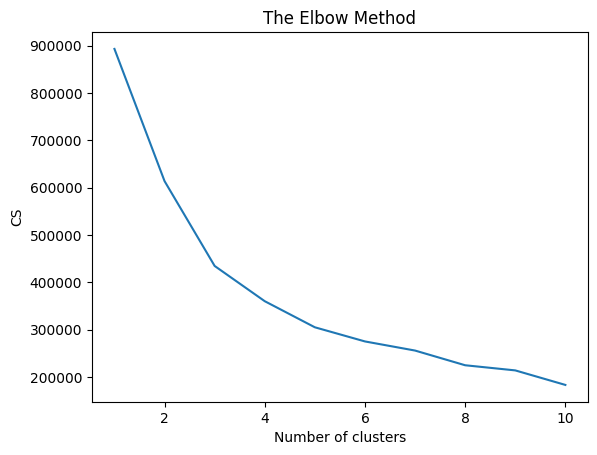

In [68]:
cs = []
for i in range(1, 11):
    km_ = Pipeline([
    ('preprocess', preprocessing_k),
    ('scaler', MinMaxScaler()),
    ('cluster', KMeans(
    n_clusters=i, init='random',
    n_init=10, max_iter=50, 
    tol=1e-04, random_state=0))])
    km_.fit(df_donations)
    cs.append(km_.named_steps.cluster.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
# plt.savefig("./results/elbowplot")
plt.show()


### Build K-means clusters with 6 clusters

In [69]:
# Randomized search cv
np.random.seed(123)
km = KMeans(
    n_clusters=6, init='random',
    n_init=10, max_iter=50, 
    tol=1e-04, random_state=0
)

#Pipeline for Random Forest tuning

km_pipe = Pipeline([
    ('preprocess', preprocessing_k),
    ('scaler', MinMaxScaler()),
    ('cluster', km)
])


y_km = km_pipe.fit_predict(df_donations)

# # ---- Serialize cluster to file
# with open("../models_all_params/kmeans_pipe.pickle", "wb") as f:
#     pickle.dump(km_pipe, f)
    
# # ---- Serialize cluster to file
# with open("../models_all_params/y_km.pickle", "wb") as f:
#     pickle.dump(y_km, f)

## Explore Cluster

### Cluster size

In [70]:
df_donations_cls = full_df.copy()
df_donations_cls["cluster"] = y_km

df_donations_cls["cluster"].value_counts().sort_index()

0     66817
1     94958
2    281144
3    198246
4    341843
5     65558
Name: cluster, dtype: int64

### Unique customers in a cluster

In [71]:
df_donations_cls.groupby("cluster")["donor_acctid"].nunique()

cluster
0     52530
1     28242
2    157160
3     75552
4    258191
5     33089
Name: donor_acctid, dtype: int64

### Which donor attributes are important in generating the clusters?

In [72]:
# ---- Using decision tree to understand how clusters
np.random.seed(123)

dtc_cls = DecisionTreeClassifier(max_depth=5)

# ---- Pipeline for decision tree

dtc_cls_pipe = Pipeline([
    ('preprocess', preprocessing_k),
    ('cls_classifier', dtc_cls)
])

dt_cls =dtc_cls_pipe.fit(df_donations[num_features_k+cat_features_k], y_km)

### Important customer attributes informing clusters

<AxesSubplot: ylabel='features'>

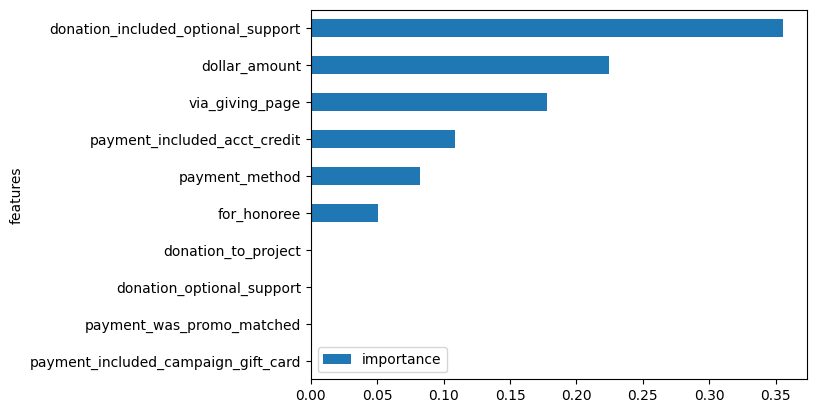

In [73]:
pd.DataFrame({"features":num_features_k+cat_features_k,
              "importance":dtc_cls_pipe.named_steps.cls_classifier.feature_importances_})\
.sort_values("importance")\
.plot.barh(x="features",y="importance")

### Decision tree for explaining the possible splits to create the clusters

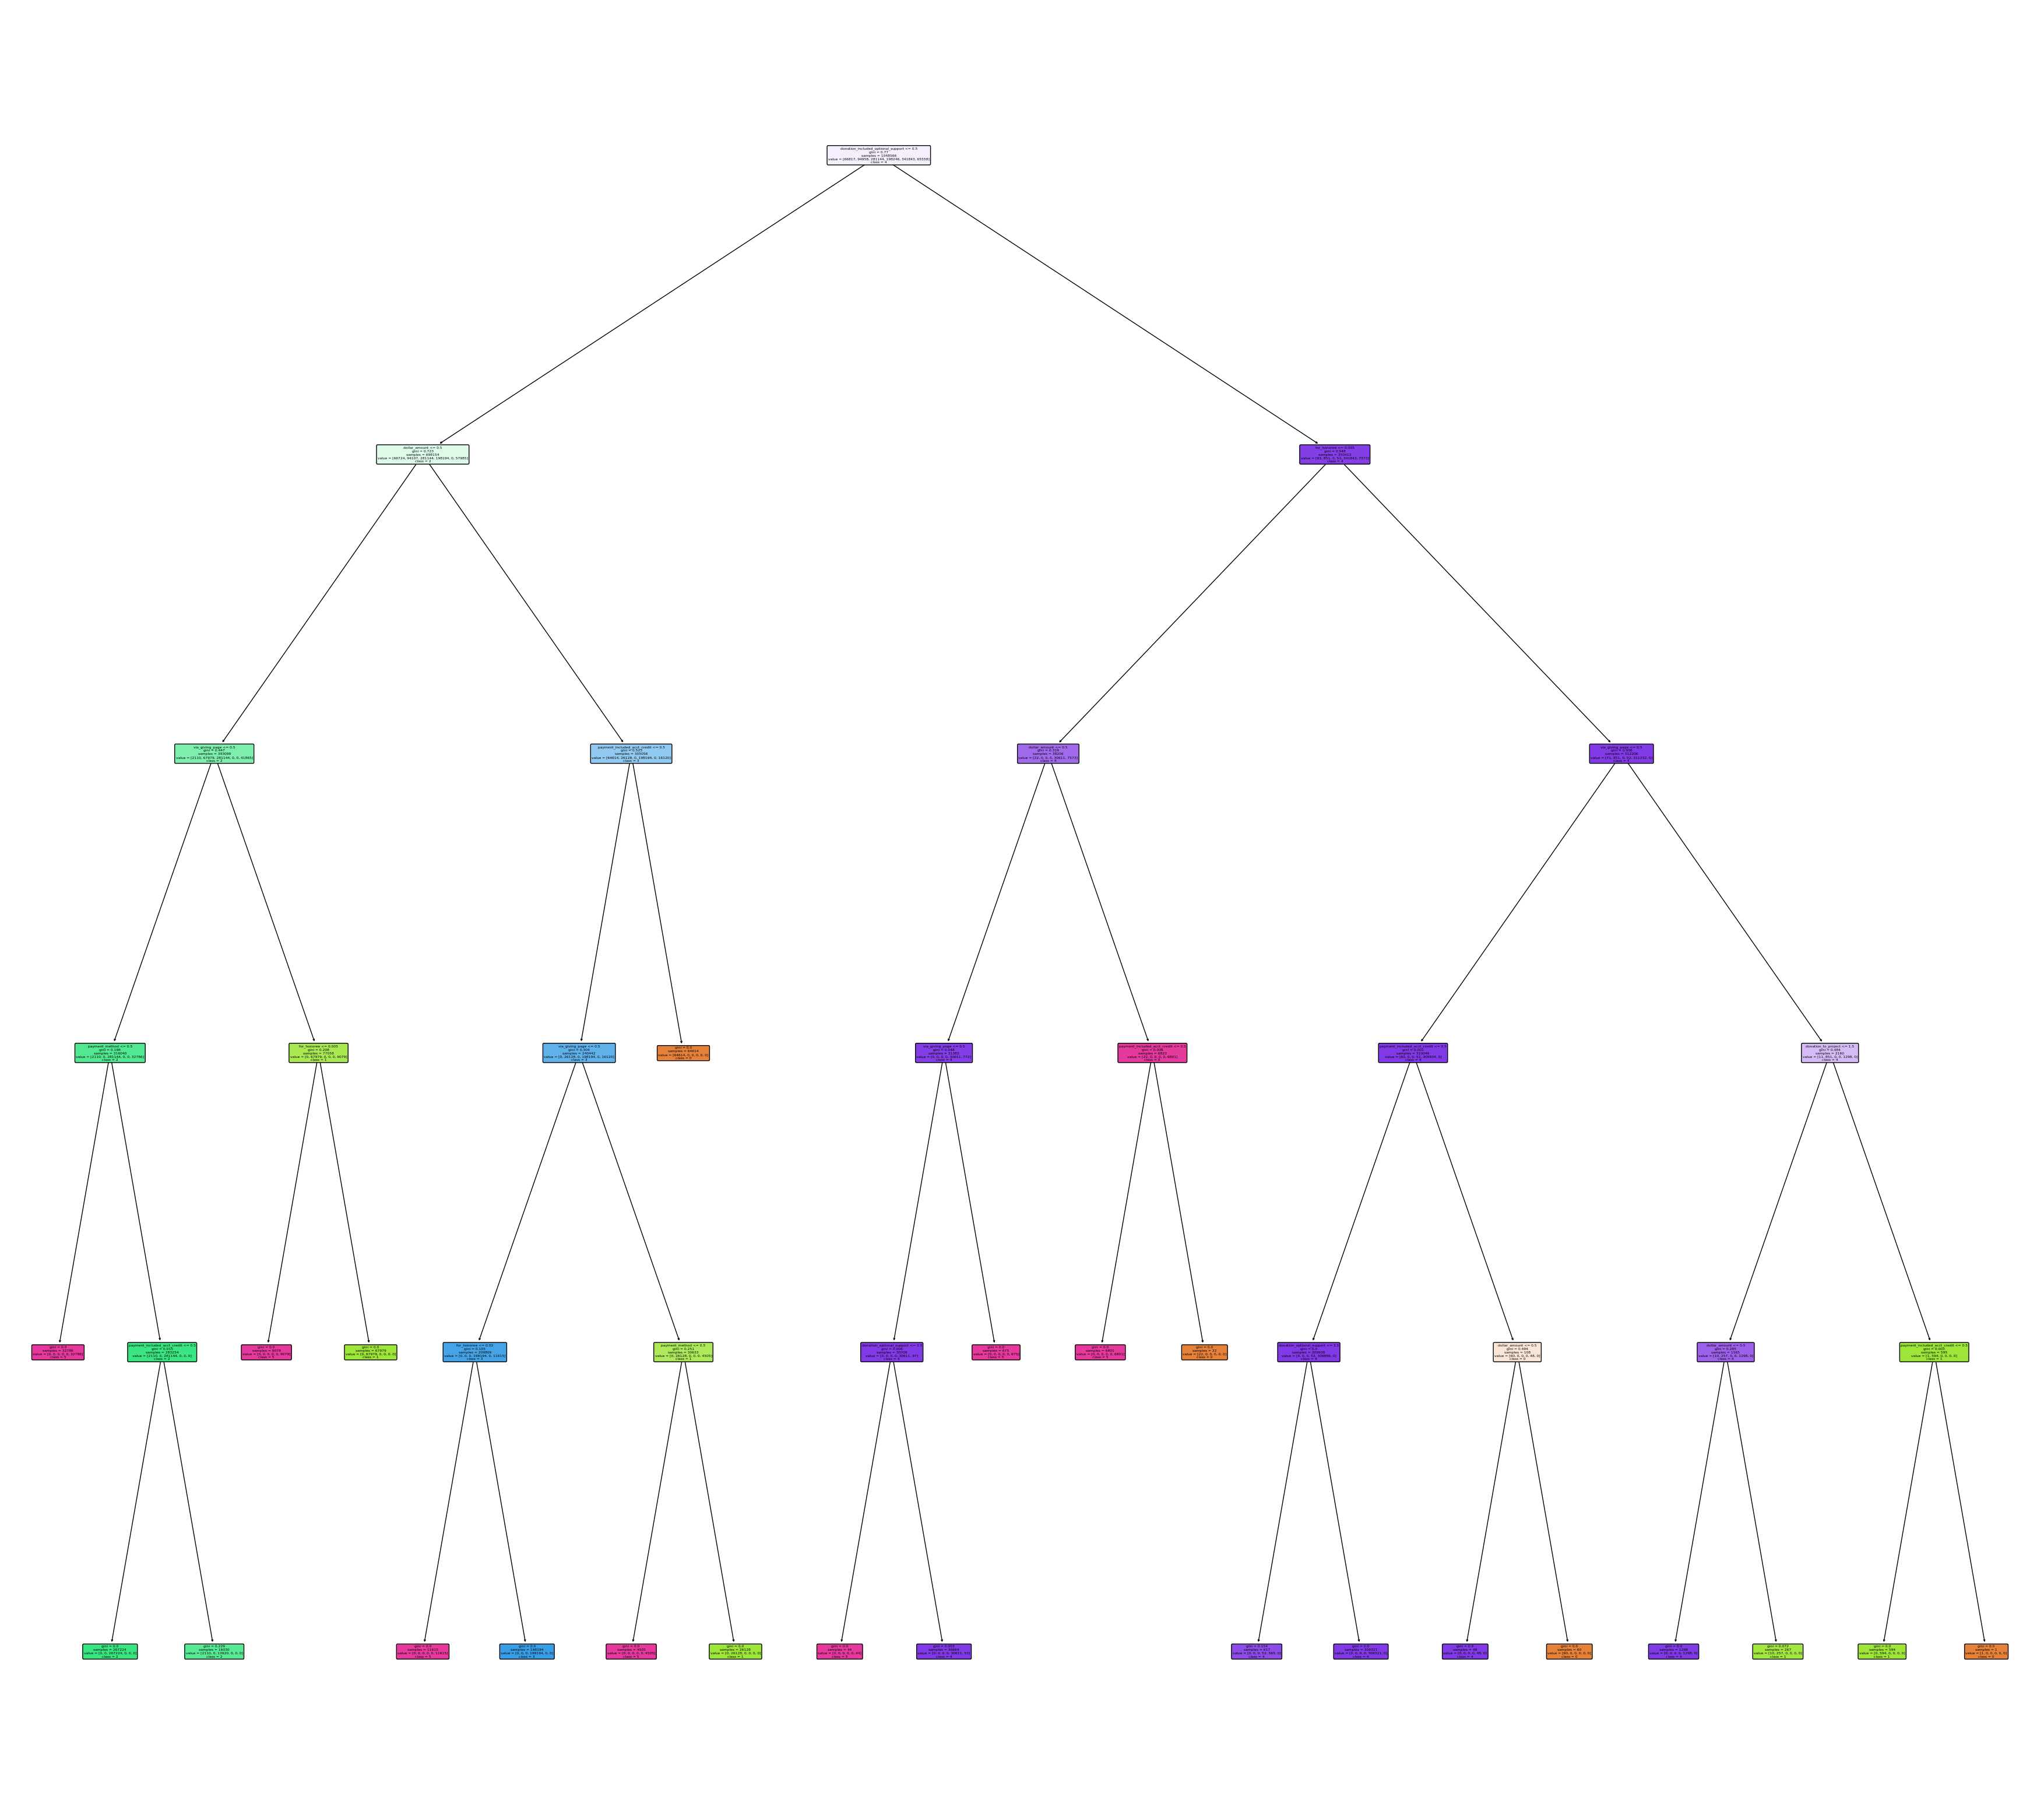

In [74]:
fig, axs = plt.subplots(1, 1, figsize=(45, 40))
plot_tree(dtc_cls_pipe.named_steps.cls_classifier, 
          ax=axs,
          feature_names=df_donations_cls[num_features_k+cat_features_k].columns,
          class_names=[str(i) for i in dt_cls.classes_],
         filled=True,
         rounded=True)
plt.savefig("../results/cluster.pdf")
plt.show()


# fig = plt.figure(figsize=(25,20))
# _ = plot_tree(dtc_cls_pipe.named_steps.cls_classifier,
#                    feature_names=df_donations_cls[num_features_k+cat_features_k].columns,  
#                    class_names=["f","t"],
#                    filled=True, )

### Profiling clusters

#### Cluster profile by amount donation amount

In [75]:
df_donations_cls.groupby("cluster")["donation_total"]\
.agg(["count", "min","median","max","mean","sum"]).sort_values("sum")

,count,min,median,max,mean,sum
cluster,,,,,,
0,66817,0.07,25.000,3562.50,41.132007,2748317.34
5,65558,0.00,25.000,60000.00,80.990599,5309581.69
4,341843,0.00,15.000,17189.12,35.179787,12025963.84
1,94958,0.04,46.875,100000.00,159.167650,15114241.68
3,198246,0.24,25.000,7372.56,98.749799,19576752.75
2,281144,0.06,39.180,24371.48,90.295418,25386014.90


#### Cluster profile by whether donation included optional support

<AxesSubplot: xlabel='donation_included_optional_support', ylabel='cluster'>

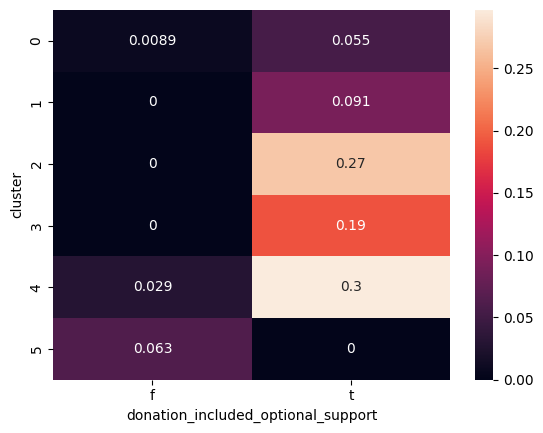

In [76]:
sns.heatmap(
pd.crosstab(index = df_donations_cls["cluster"],
            columns = df_donations_cls["donation_included_optional_support"],
           normalize=True),annot=True)

#### Cluster profile by donation was via giving page or campaign page

<AxesSubplot: xlabel='via_giving_page', ylabel='cluster'>

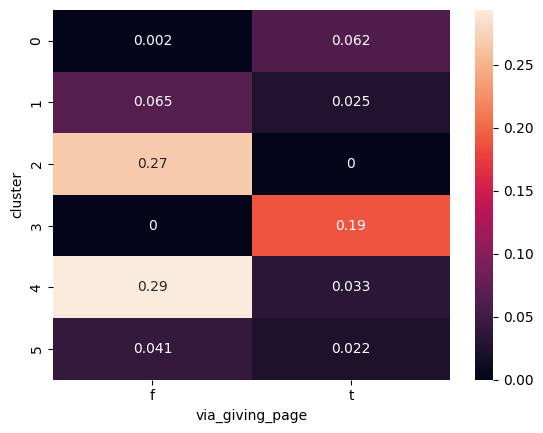

In [77]:
sns.heatmap(
pd.crosstab(index = df_donations_cls["cluster"],
            columns = df_donations_cls["via_giving_page"],
           normalize=True),annot=True)

<AxesSubplot: xlabel='payment_included_acct_credit', ylabel='cluster'>

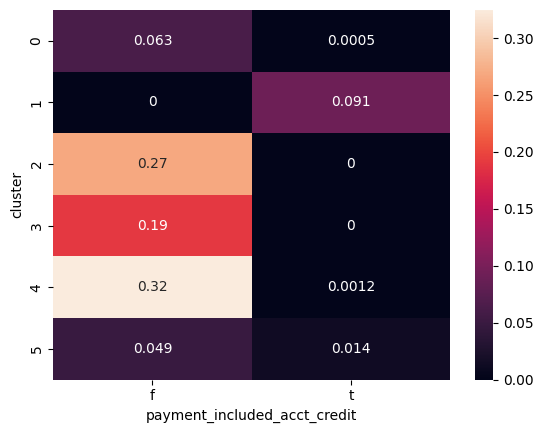

In [78]:
sns.heatmap(
pd.crosstab(index = df_donations_cls["cluster"],
            columns = df_donations_cls["payment_included_acct_credit"],
           normalize=True,),annot=True)

#### Cluster profile by whether payment was for an honoree

<AxesSubplot: xlabel='for_honoree', ylabel='cluster'>

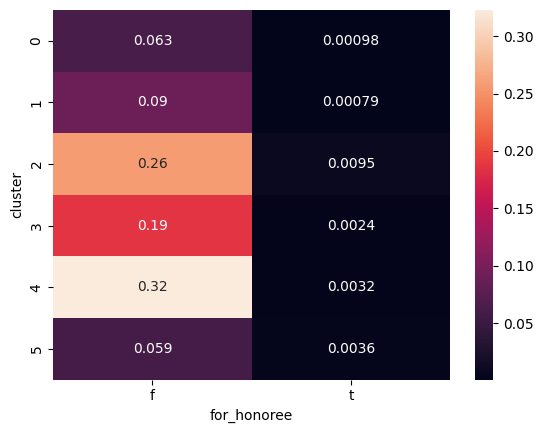

In [79]:
sns.heatmap(
pd.crosstab(index = df_donations_cls["cluster"],
            columns = df_donations_cls["for_honoree"],
           normalize=True,),annot=True)

#### Cluster profile by payment git card

<AxesSubplot: xlabel='payment_included_campaign_gift_card', ylabel='cluster'>

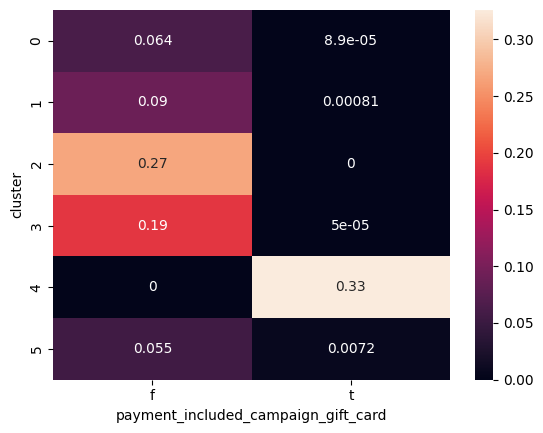

In [80]:
sns.heatmap(
pd.crosstab(index = df_donations_cls["cluster"],
            columns = df_donations_cls["payment_included_campaign_gift_card"],
           normalize=True,),annot=True)

#### Cluster profile by payment promo

<AxesSubplot: xlabel='payment_was_promo_matched', ylabel='cluster'>

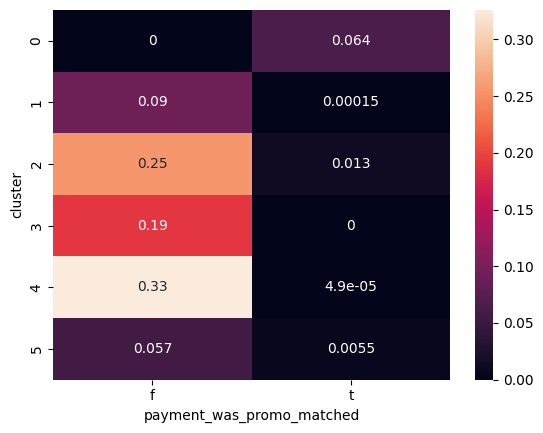

In [81]:
sns.heatmap(
pd.crosstab(index = df_donations_cls["cluster"],
            columns = df_donations_cls["payment_was_promo_matched"],
           normalize=True,),annot=True)

#### Cluster profile by dollar amount

<AxesSubplot: xlabel='dollar_amount', ylabel='cluster'>

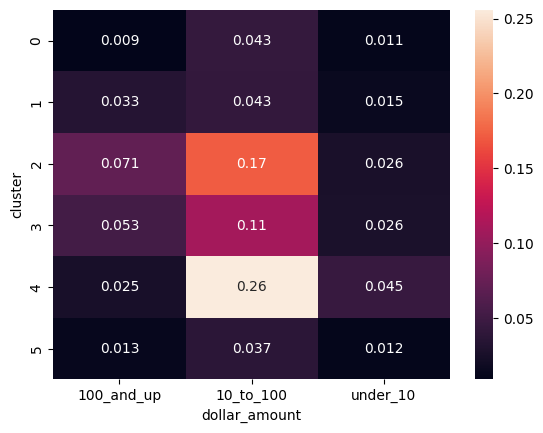

In [82]:
sns.heatmap(
pd.crosstab(index = df_donations_cls["cluster"],
            columns = df_donations_cls["dollar_amount"],
           normalize=True,),annot=True)

#### Cluster profile by payment method

<AxesSubplot: xlabel='payment_method', ylabel='cluster'>

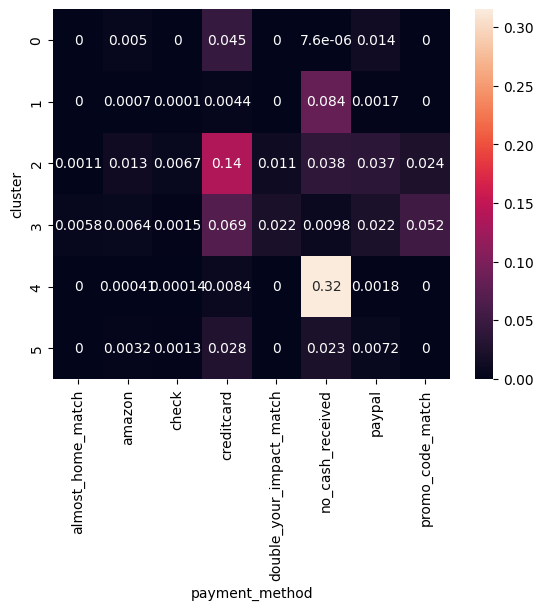

In [83]:
sns.heatmap(
pd.crosstab(index = df_donations_cls["cluster"],
            columns = df_donations_cls["payment_method"],
           normalize=True,),annot=True)